In [1]:
'''

load original df

'''

import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
import re
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once

dataFilePath = os.path.join(os.getcwd(),'Data')

#kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
#lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
sns.set(font_scale=1.5)

dog = kicsTEdf.columns
print(dog.tolist())
print(kicsTEdf.head(30))
print(lfsTEdf.columns)
print(lfsTEdf.head(30))

#keep SV_chrom, SV_length, SV_type, Location, Location2, 

#AnnotSV type => Annotation_mode



['AnnotSV_ID', 'SV_chrom', 'SV_start', 'SV_end', 'SV_length', 'SV_type', 'Samples_ID', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'xTea', 'MELT', 'Annotation_mode', 'CytoBand', 'Gene_name', 'Gene_count', 'Tx', 'Tx_start', 'Tx_end', 'Overlapped_tx_length', 'Overlapped_CDS_length', 'Overlapped_CDS_percent', 'Frameshift', 'Exon_count', 'Location', 'Location2', 'Dist_nearest_SS', 'Nearest_SS_type', 'Intersect_start', 'Intersect_end', 'RE_gene', 'P_gain_phen', 'P_gain_hpo', 'P_gain_source', 'P_gain_coord', 'P_loss_phen', 'P_loss_hpo', 'P_loss_source', 'P_loss_coord', 'P_ins_phen', 'P_ins_hpo', 'P_ins_source', 'P_ins_coord', 'P_snvindel_nb', 'P_snvindel_phen', 'B_gain_source', 'B_gain_coord', 'B_gain_AFmax', 'B_loss_source', 'B_loss_coord', 'B_loss_AFmax', 'B_ins_source', 'B_ins_coord', 'B_ins_AFmax', 'B_inv_source', 'B_inv_coord', 'B_inv_AFmax', 'TAD_coordinate', 'ENCODE_experiment', 'GC_content_left', 'GC_content_right', 'Repeat_coord_left', 'Repeat_type_left', 'Repeat_coord_r

In [3]:
"""
Kics clinic df cleaning
"""
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


In [4]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
        
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

In [5]:
"""
'ALT' Clean up
"""

kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace("<INS:ME:","")
kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace(">","")

lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace("<INS:ME:","")
lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace(">","")
print(lfsTEdf['ALT'].value_counts())

#print(lfsTEdf['ALT'].value_counts())

ALU      90163
LINE1     4342
SVA       2712
Name: ALT, dtype: int64


In [6]:
"""
Filtering and cleaning Samples_ID
"""
kicsTEF = kicsTEdf.loc[(kicsTEdf['Annotation_mode'] == 'full')]
lfsTEF = lfsTEdf.loc[(lfsTEdf['Annotation_mode'] == 'full')]

kicsTEF['SV_chrom'] = kicsTEF['SV_chrom'].astype(str)
lfsTEF['SV_chrom'] = lfsTEF['SV_chrom'].astype(str)

kicsTEF['Samples_ID'] = kicsTEF['Samples_ID'].astype(str).str.replace(".realigned-recalibrated","")
lfsTEF['Samples_ID'] = lfsTEdf['Samples_ID'].astype(str).str.replace('.realigned-recalibrated', '')

kicsTEF.drop(kicsTEF.loc[pd.isna(kicsTEF['Samples_ID'])].index, inplace=True)
lfsTEF.drop(lfsTEF.loc[pd.isna(lfsTEF['Samples_ID'])].index, inplace=True)

kicsTEnum = kicsTEF['Samples_ID'].count()
lfsTEnum = lfsTEF['Samples_ID'].count()

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
for i in listValSearch: 
    kicsTEF.drop(kicsTEF[kicsTEF['Samples_ID'].str.contains(i)==True].index, inplace = True)
    

mergedTEdf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 'kChrom':kicsTEF['SV_chrom'], 
                                  'kAlt':kicsTEF['ALT'], 'lAlt':lfsTEF['ALT'],
                                  'kID':kicsTEF['Samples_ID'], 'lID': lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type'], 'lChrom':lfsTEF['SV_chrom']})

In [7]:
"""
Cleaning kics ids
"""
def kIdAbbv(clinicDf, svDf, clinicCol, svCol):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
    
    df = pd.merge(svDf[[svCol,'SV_type','abbv_id','ALT']],                   
                     clinicDf[[clinicCol, 'tumour_class','tissue_type',
                               'lfs_cancer_type_diagnosis', 'abbv_id','diagnosis_age (days)']],
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')
    return df

In [8]:
"""
Make big k df
"""
bigKdf = kIdAbbv(kicsClinicdf, kicsTEF, 'CCP germline', 'Samples_ID')

79


In [9]:
"""
Make a big lfs df
"""
bigLdf = pd.merge(lfsTEF[['Samples_ID','SV_type','ALT']],
                 lfsClinicdf[['sample','tissue_type','cancer_diagnosis','ageofonset']],
                 left_on = 'Samples_ID',
                 right_on = 'sample',
                 how='inner')
             
bigKdf = bigKdf.rename(columns={'diagnosis_age (days)': 'ageofonset', 'CCP germline':'sample',
                                'lfs_cancer_type_diagnosis':'cancer_diagnosis'})

In [10]:
from matplotlib import pyplot as plt

def boxplotPoints(title:list, column:list, df: pd.DataFrame , sizeH=20.50, sizeV=17.50, col='red', trans=0.25, outliers = True):
    plt.rcParams["figure.figsize"] = [sizeH, sizeV]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({
        t: df[c] for t,c in zip(title, column)})
    
    #print(data)
    plotTest = data
    plotTest = plotTest.stack().to_frame().reset_index().rename(columns={'level_1': 'iden', 0: 'value'}).drop('level_0', axis='columns')
    plotTest['cat'] = 1
    #print(plotTest.head(50))
    #data.boxplot()
    #BoxGraphMulti(plotTest, 'cat', 'value', 'iden')
    sns.boxplot(data=plotTest, x='iden', y='value', medianprops={"linewidth": 8, "color": 'black'}, showfliers = outliers)
    
    #plot with boxplot
    if outliers:
        sns.stripplot(x = 'iden',
                  y = 'value',
                      color = 'red',
                      alpha = 0.25,
                  data = plotTest)
    
    list1 = df[column[0]].dropna()
    list2 = df[column[1]].dropna()
    print(mannwhitneyu(list1,list2))
    plt.show()

titles = ['kics','lfs']
columns = titles


In [11]:
"""

1. Graph for frequency of SV types
2. Graphs for frequency of SV types specific to chromosomes

Function to graph bar graphs

"""

def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
    
    plt.bar(x_axis - 0.2, [count1[a] for a in labels]/divisor1, 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a] for a in labels]/divisor2, 0.4, label = label2)

    plt.xticks(x_axis, labels)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()
    
xLabels = ['DEL','DUP','INV']
uniqueLabels = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']


In [12]:
"""

Testing group by

"""
#probably a better way to do this

kicsSVTypedf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 
                                  'kId':kicsTEF['Samples_ID']})
lfsSVTypedf = pd.DataFrame(data = {'lId':lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type']})

#temp = mergedTEdf.groupby(['kId']).value_counts() #not sure how to use this, unsure if it's missing anything

##kics
ktemp = kicsSVTypedf.groupby(['kId']).value_counts()

##lfs
ltemp = lfsSVTypedf.groupby(['lId']).value_counts()

#print(ktemp.head(30))
#print(ktemp.index.get_level_values(0))

#get unique identifiers

uniqueK = kicsSVTypedf['kId'].unique()
uniqueL = lfsSVTypedf['lId'].unique()

#probably a better way, but itterate through the series and get the data 

def makeDataSet(identifiers, series: pd.Series, secondIndex: str)->list:
    
    dataList = []
    
    for i in identifiers:
        try:
            dataList.append(series[(i, secondIndex)])
        except:
            #pass
            dataList.append(0)

    return(dataList)


        
def makeUnequalDF(list1: list, list2: list) -> pd.DataFrame: #only for kics vs lfs D:
    tempDict = dict(kics = list1, lfs = list2)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in tempDict.items()]))
    return df

# SV Type

In [13]:
kINSData = makeDataSet(uniqueK, ktemp, 'INS')
#print(kINSData)
lINSData = makeDataSet(uniqueL, ltemp, 'INS')
#print(lINSData)
tempINSDF = makeUnequalDF(kINSData, lINSData)

#print(tempINSDF)

## INS

MannwhitneyuResult(statistic=3434.5, pvalue=0.00010322632415350713)


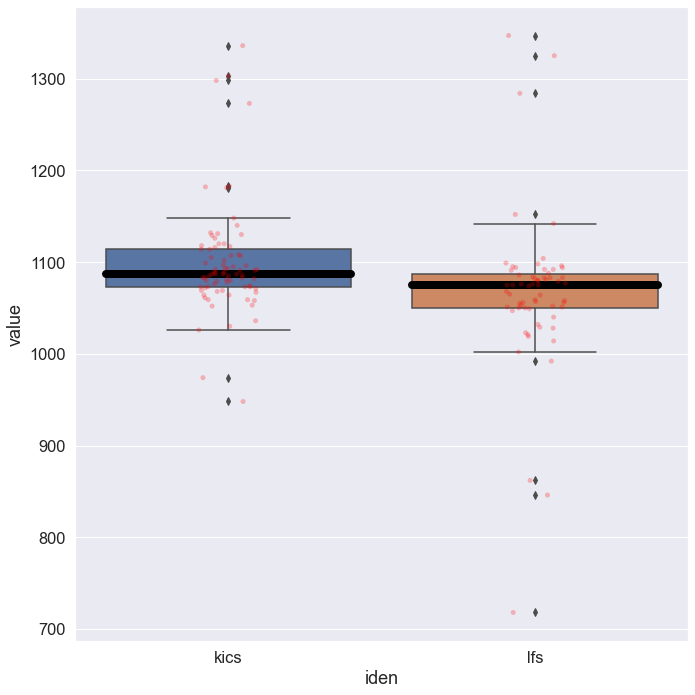

Index(['kics', 'lfs'], dtype='object')
Empty DataFrame
Columns: [kics, lfs]
Index: []


In [14]:
boxplotPoints(titles, columns, tempINSDF, 10, 10)

#print(mergedTEdf[mergedTEdf['lfs']<200])
print(tempINSDF.columns)

print(tempINSDF.loc[tempINSDF['lfs']<200])

In [15]:
"""

Chromosome Specific
Cleaned up

"""

def formatDataFrame(df: pd.DataFrame, groupByList: list, normalizeList: list, 
                    iterateList: list, labels: list, typeSV: str ) -> tuple:
    
    dfGrouped = df.groupby(groupByList).size().unstack(fill_value=0)
    #print(dfGrouped)
    dfReg = pd.DataFrame()
    dfNorm = pd.DataFrame()
    df1WC = pd.DataFrame()
    df2WC = pd.DataFrame()
    
    for i in iterateList:
        tempList = []
        
        try:
            series = dfGrouped.loc[(i,typeSV)]
            #print(series)
            
        except:
            series = pd.Series(0, index=labels)
            
        for j,div in zip(labels, normalizeList):
            tempList.append(series[j]/div)
            
        d = {'chrom':labels, 'normalized':tempList}
        tempdf = pd.DataFrame(d)

        dfNorm = pd.concat([dfNorm, tempdf], axis=0)
        dfReg = pd.concat([dfReg, series], axis=0) 
    
    return(dfReg, dfNorm)

def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol):
    orderList = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'},
                order= orderList)
    
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        p1 = (i, 'kics')
        p2 = (i, 'lfs')
        p = (p1,p2)
        listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol,order=orderList)
    annot.configure(test='Mann-Whitney', comparisons_correction='BH',correction_format='replace',
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()
    


kicsMore = pd.DataFrame(data = {'SV':kicsTEF['SV_type'], 'chrom':kicsTEF['SV_chrom'], 
                                  'id':kicsTEF['Samples_ID']})
lfsMore = pd.DataFrame(data = {'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom'],
                                  'SV':lfsTEF['SV_type']})

numBPChrom = [249250621, 243199373, 198022430, 191154276, 180915260, 
              171115067, 159138663, 146364022, 141213431, 135534747,
              135006516, 133851895, 115169878, 107349540, 102531392,
              90354753, 81195210, 78077248, 59128983, 63025520,
              48129895, 51304566, 155270560, 59373566]

grouping = ['id', 'SV', 'chrom']


'''
If you have time, you should make it so that the plot can have the points showing/scattered plot
'''


'\nIf you have time, you should make it so that the plot can have the points showing/scattered plot\n'

ALT        ALU  LINE1  SVA dataset
id                                
19_18442   974     54   39    kics
245676     956     54   20    kics
271113    1019     48   28    kics
271114    1014     52   20    kics
271115    1030     55   35    kics
...        ...    ...  ...     ...
323274    1008     57   20    kics
328067    1097     50   34    kics
5510      1003     49   29    kics
5511      1031     48   28    kics
5547      1016     49   22    kics

[79 rows x 4 columns]


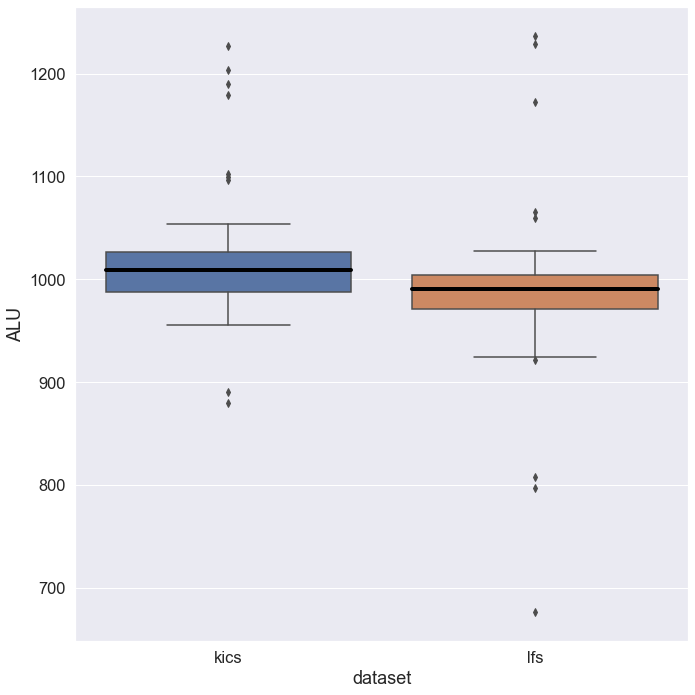

MannwhitneyuResult(statistic=3405.5, pvalue=0.00016735464124410167)


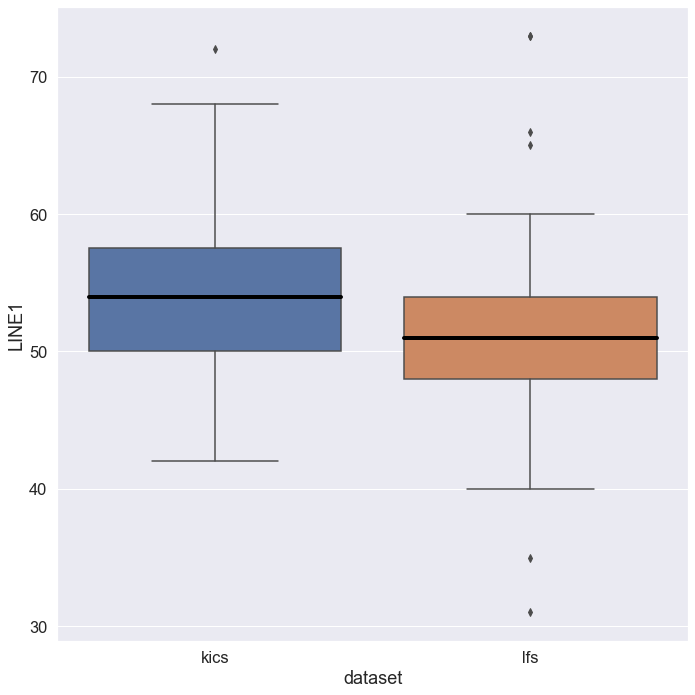

MannwhitneyuResult(statistic=3296.0, pvalue=0.0008982191122282993)


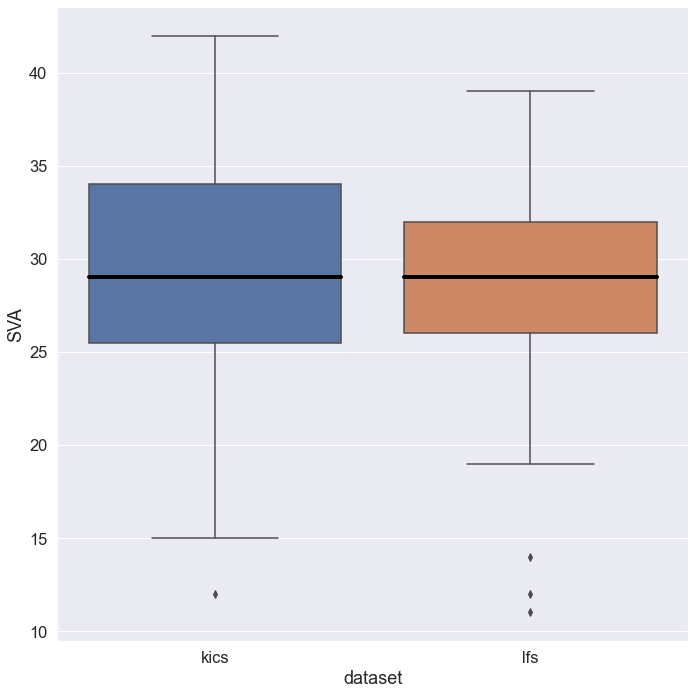

MannwhitneyuResult(statistic=2608.0, pvalue=0.6244689679773743)


In [16]:
"""
ALU, LINE1, SVA
"""

kicsALT = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID']})
lfsALT = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID']})

kicsALT = kicsALT.groupby('id')
kicsALT = kicsALT.value_counts().to_frame()
kicsALT = kicsALT.unstack(1)
kicsALT.columns = kicsALT.columns.droplevel(0)
kicsALT['dataset'] = 'kics'
print(kicsALT)

lfsALT = lfsALT.groupby('id')
lfsALT = lfsALT.value_counts().to_frame()
lfsALT = lfsALT.unstack(1)
lfsALT.columns = lfsALT.columns.droplevel(0)
lfsALT['dataset'] = 'lfs'

testing = pd.concat([kicsALT,lfsALT])
testing = testing.reset_index()
#print(testing)

#plt.rcParams["figure.figsize"] = [5, 10]

sns.boxplot(data=testing, x='dataset', y='ALU', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['ALU'].dropna(),lfsALT['ALU'].dropna()))
#list1 = df[column[0]].dropna()
#        list2 = df[column[1]].dropna()
#        print(mannwhitneyu(list1,list2))



sns.boxplot(data=testing, x='dataset', y='LINE1', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['LINE1'].dropna(),lfsALT['LINE1'].dropna()))

sns.boxplot(data=testing, x='dataset', y='SVA', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['SVA'].dropna(),lfsALT['SVA'].dropna()))

#BoxGraphMulti(testing, '', 'id', 'dataset')

Index(['ALU', 'LINE1', 'SVA'], dtype='object', name='ALT')
   chrom    normalized
0      1  2.928779e-07
1      2  3.947379e-07
2      3  3.888448e-07
3      4  3.871219e-07
4      5  3.150646e-07
..   ...           ...
19    20  2.855986e-07
20    21  2.701024e-07
21    22  1.754230e-07
22     X  7.728445e-08
23     Y  0.000000e+00

[1896 rows x 2 columns]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.731e-01 U_stat=2.626e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.566e-03 U_stat=3.258e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.154e-01 U_stat=2.733e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg 

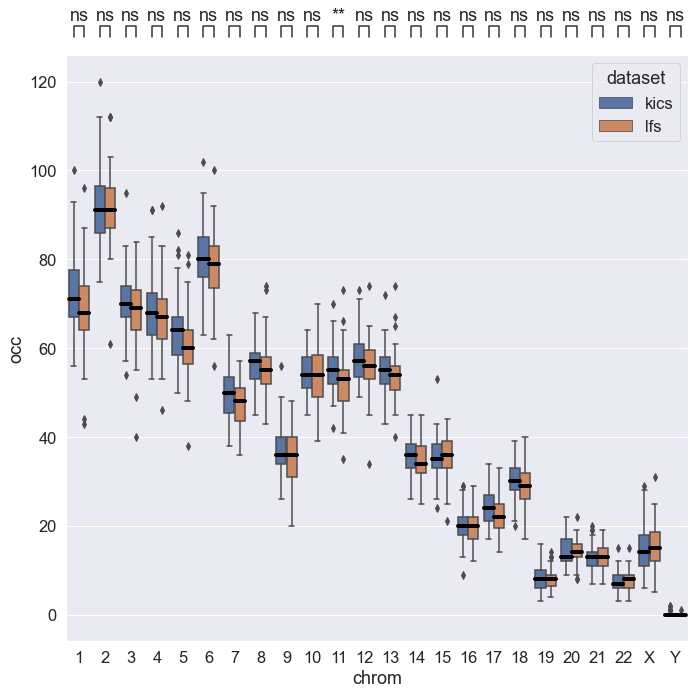

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.731e-01 U_stat=2.626e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.566e-03 U_stat=3.258e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.154e-01 U_stat=2.733e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.001e-01 U_stat=2.888e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.403e-01 U_stat=2.720e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.107e-01 U_stat=2.398e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided with B

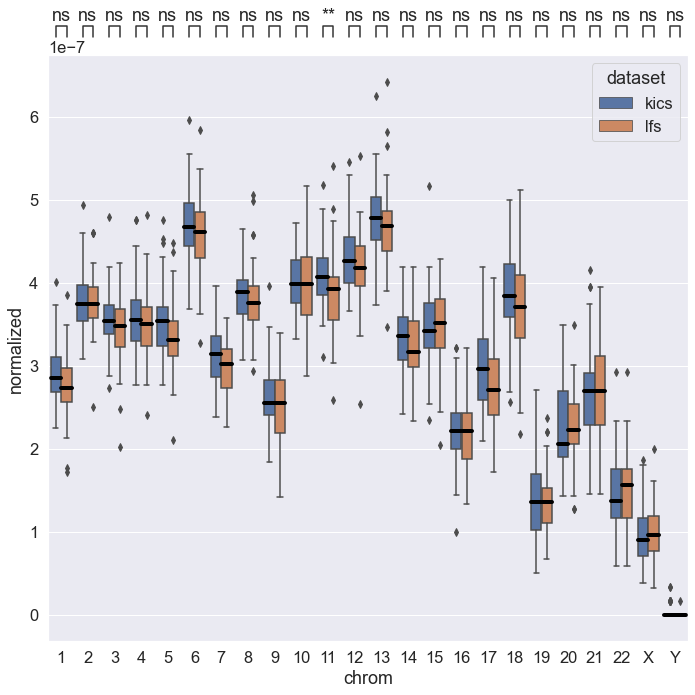

In [17]:
"""
Based on chrom
"""

kicsChromAlt = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID'], 'chrom':kicsTEF['SV_chrom']})
lfsChromAlt = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom']})

#print(kicsChromAlt.columns)
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['LINE1','SVA'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['LINE1','SVA'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'ALU')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'ALU')

print(normAltKdf)
# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))
    
    

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

##ALU

plt.rcParams["figure.figsize"] = [10, 10]
BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')
    

Index(['ALU', 'LINE1', 'SVA'], dtype='object', name='ALT')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.356e-01 U_stat=2.591e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.081e-01 U_stat=2.609e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.856e-01 U_stat=2.798e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.968e-01 U_stat=2.581e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.045e-01 U_stat=2.118e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.442e-01 U_stat=2.271e+03
16_k

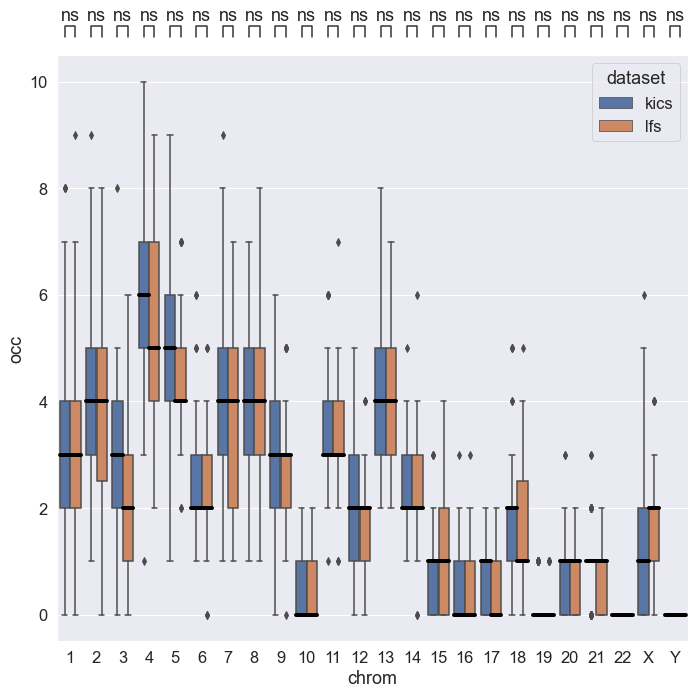

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.356e-01 U_stat=2.591e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.081e-01 U_stat=2.609e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.856e-01 U_stat=2.798e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.968e-01 U_stat=2.581e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.045e-01 U_stat=2.118e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.442e-01 U_stat=2.271e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided with B

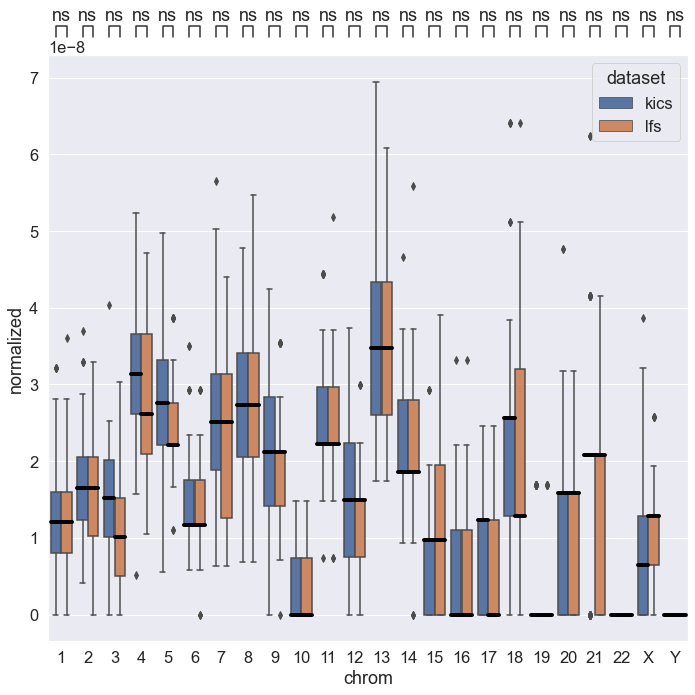

In [18]:
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['ALU','SVA'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['ALU','SVA'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'LINE1')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'LINE1')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###LINE1

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')

Index(['ALU', 'LINE1', 'SVA'], dtype='object', name='ALT')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.216e-01 U_stat=2.672e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.847e-01 U_stat=2.494e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.928e-01 U_stat=2.614e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.842e-01 U_stat=2.244e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.131e-01 U_stat=2.256e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.268e-01 U_stat=2.411e+03
16_k

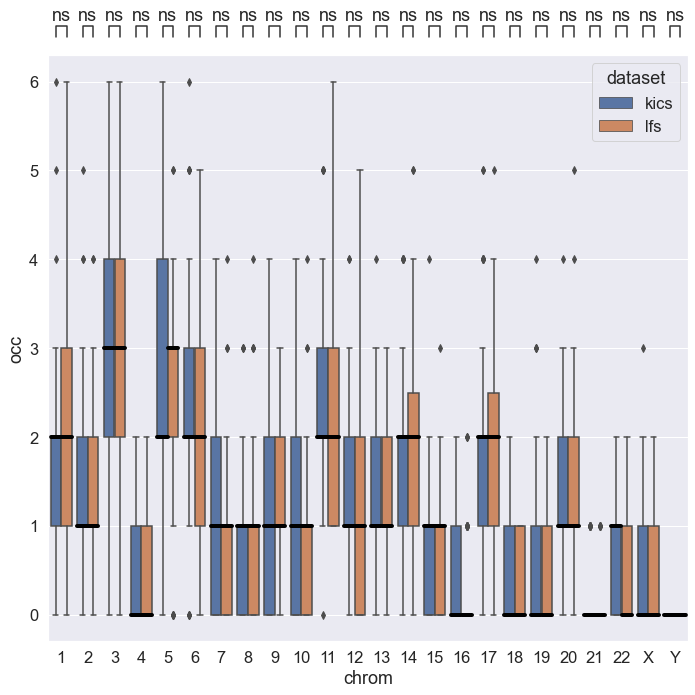

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.216e-01 U_stat=2.672e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.847e-01 U_stat=2.494e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.928e-01 U_stat=2.614e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.842e-01 U_stat=2.244e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.131e-01 U_stat=2.256e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.268e-01 U_stat=2.411e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided with B

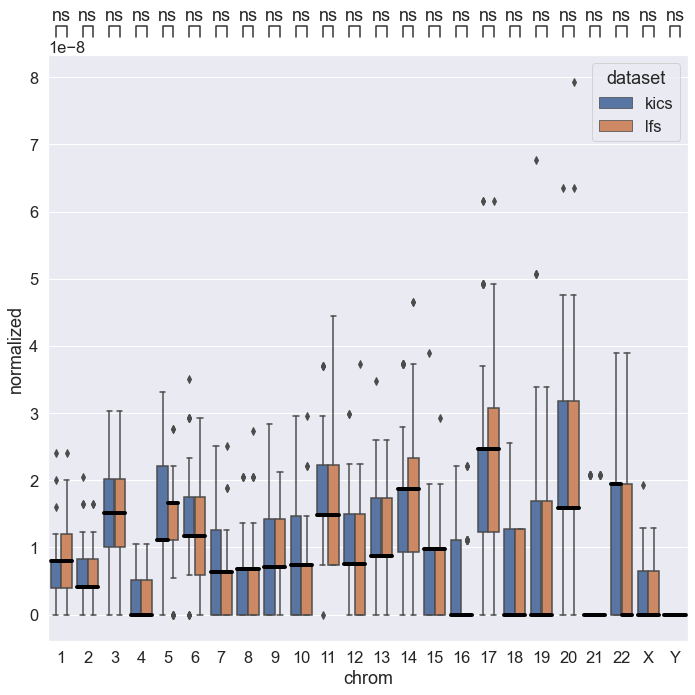

In [19]:
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['LINE1','ALU'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['LINE1','ALU'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'SVA')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'SVA')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###SVA

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')

DGOOOOOGG
     chrom   occ dataset
0        1  80.0    kics
1       10  54.0    kics
2       11  60.0    kics
3       12  64.0    kics
4       13  60.0    kics
...    ...   ...     ...
3403     7  45.0     lfs
3404     8  60.0     lfs
3405     9  49.0     lfs
3406     X  14.0     lfs
3407     Y   0.0     lfs

[3408 rows x 3 columns]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.278e-01 U_stat=2.642e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.340e-03 U_stat=3.228e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.964e-02 U_stat=2.902e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.282e-

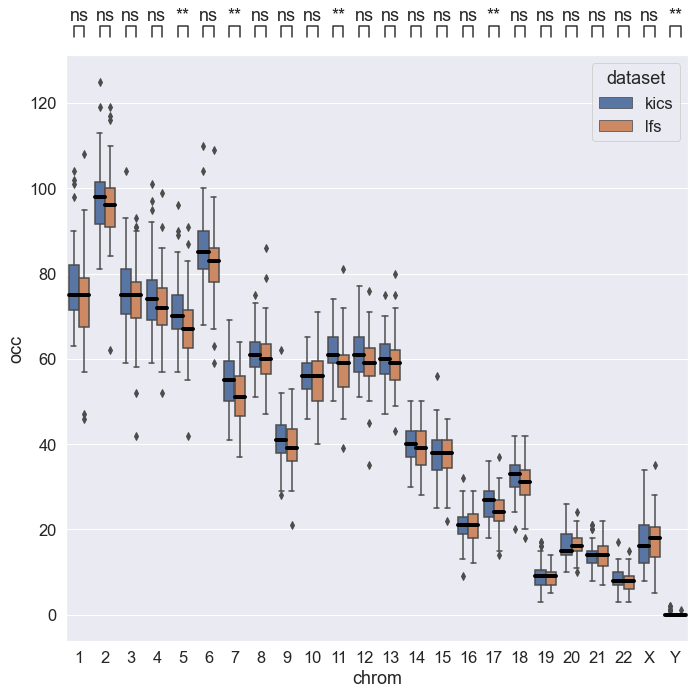

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.278e-01 U_stat=2.642e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.340e-03 U_stat=3.228e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.964e-02 U_stat=2.902e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.282e-01 U_stat=2.858e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.655e-01 U_stat=2.594e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.727e-01 U_stat=2.351e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided with B

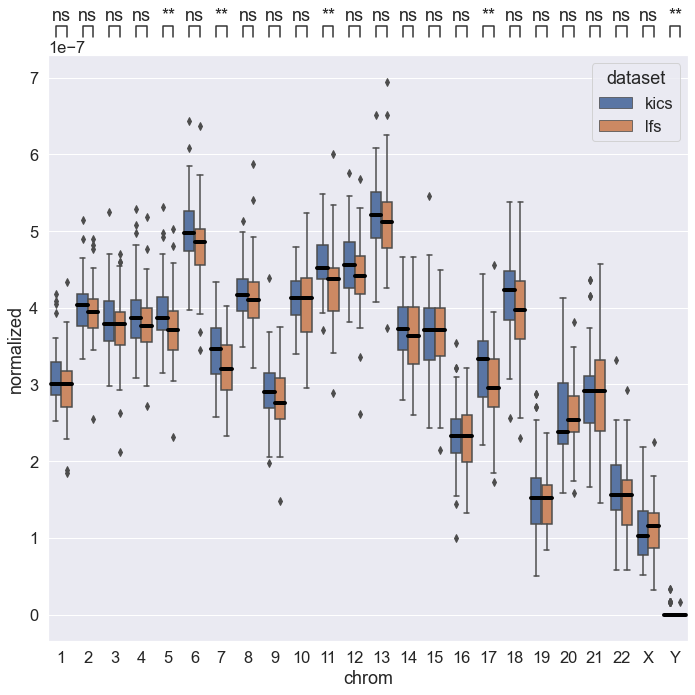

In [20]:
"""
Normalised and Regular Graph
"""

#rename things later and put into function/i but this is the statistical test T-T
dog = kicsMore.groupby(grouping).size().unstack(fill_value=0)
#print(dog)
dog = dog.stack().unstack(1)
dog = dog.stack().unstack(1)

cat = lfsMore.groupby(grouping).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.stack().unstack(1)




newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'INS')
newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'INS')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

#print(newKdf.index)
#print(newKdf.pivot( columns='index', values=0))

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newKdf, newLdf])
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

print("DGOOOOOGG")
print(newMergedDf)

BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')

normMergedDf = pd.concat([normKdf, normLdf])
normMergedDf.reset_index(inplace=True)

BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')

# Copy and Pasted from Cancer Graphs

In [21]:
""" 
Replacement for box graph multi
"""
plt.rcParams["figure.figsize"] = [20, 15]

def BoxGraphMultii(df: pd.DataFrame, xCol, yCol, compCol, orderList):    
    
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'}, showfliers=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
    
    lfs = df[df[compCol]=='lfs']
    kics = df[df[compCol]=='kics']
    
    excludeList = list(set(lfs[xCol]).symmetric_difference(set(kics[xCol])))

    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        if i not in excludeList:
            p1 = (i, 'kics')
            p2 = (i, 'lfs')
            p = (p1,p2)
            listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()

['SVA' 'LINE1' 'ALU']
  Samples_ID age6  freq
6     284386  >=6  4516
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.008e-03 U_stat=1.150e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.133e-04 U_stat=9.350e+01


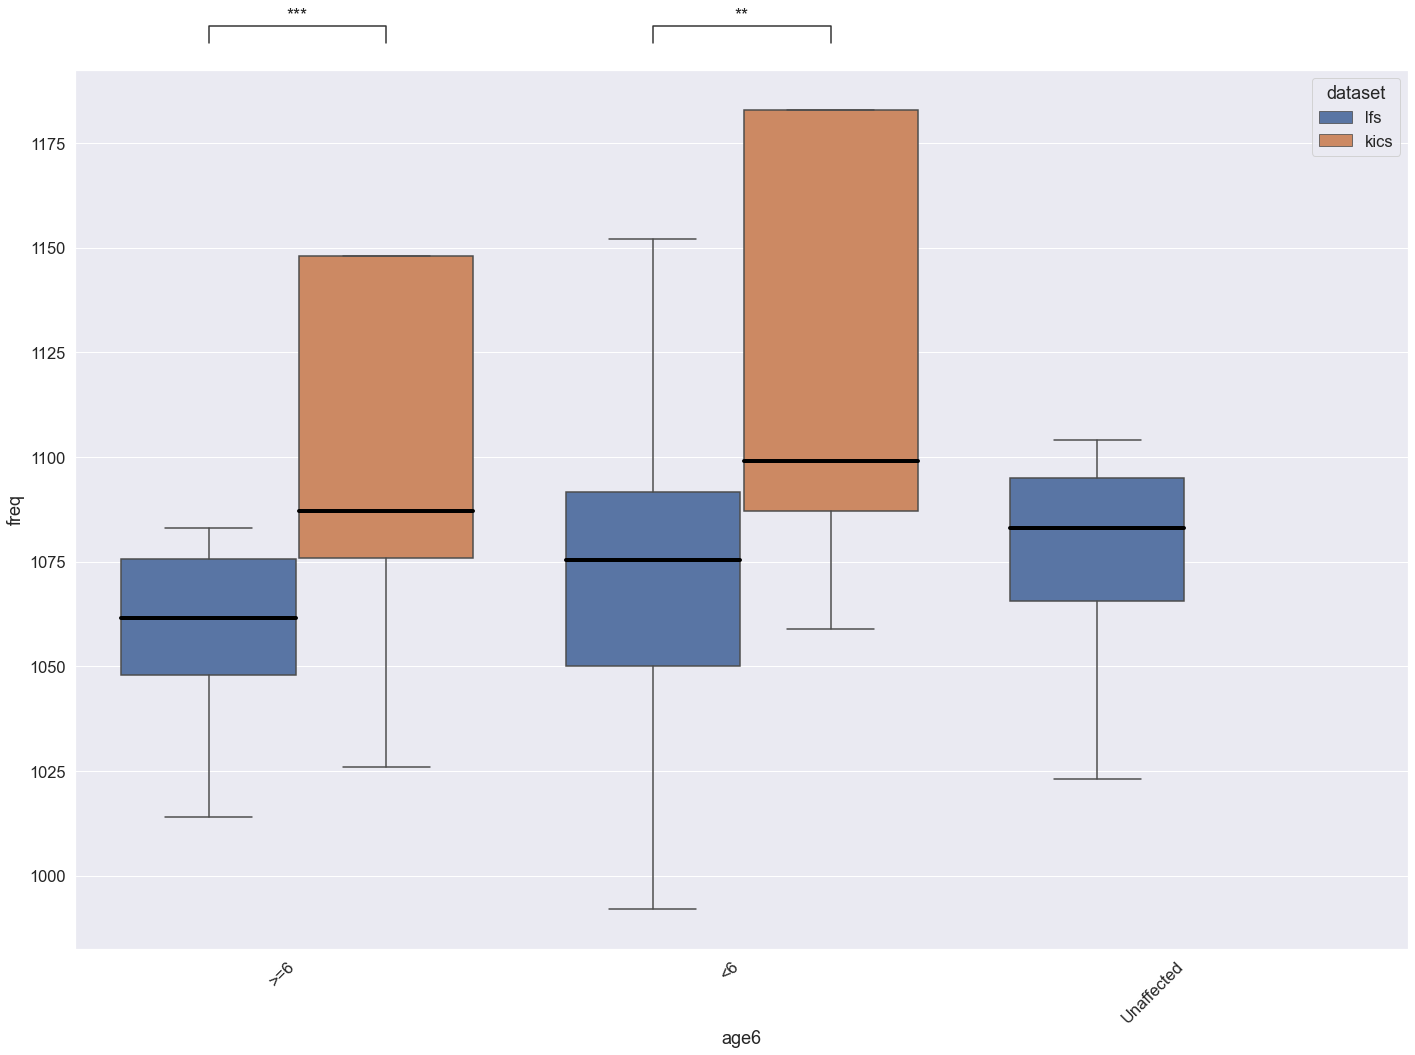

In [22]:
"""
Age of onset
"""
lfsCancer = bigLdf[bigLdf['tissue_type']!='Unaffected'].drop(['sample', 'tissue_type',
                                                             'cancer_diagnosis','SV_type'],axis=1)
lfsUnaffected = bigLdf[bigLdf['tissue_type']=='Unaffected'].drop(['sample', 'tissue_type',
                                                            'cancer_diagnosis','SV_type'],axis=1)

kicsCancer = bigKdf.drop(['abbv_id', 'SV_type', 'sample', 'tumour_class',
                          'tissue_type','cancer_diagnosis'],axis=1)

def ageOfOnsetKics(row):
    if row['ageofonset']<2190:
        return '<6'
    if row['ageofonset']>=2190:
        return '>=6'
    
def ageOfOnsetLfs(row):
    if row['ageofonset']<72:
        return '<6'
    if row['ageofonset']>=72:
        return '>=6'

def cleaning(df):
    df = df.drop(['ALT','ageofonset'],axis=1)
    df = df.groupby(['Samples_ID']).value_counts()
    df = df.to_frame().reset_index()
    df.rename(columns = {0: 'freq'},inplace = True)
    return df

def mergeDFs(lfs1, lfs2, kics1):
    lfs1 = cleaning(lfs1)
    lfs2 = cleaning(lfs2)
    kics1 = cleaning(kics1)
    print(kics1.loc[kics1['freq']>4000])
    lfsMerged = pd.concat([lfs1,lfs2])
    lfsMerged['dataset'] = 'lfs'
    kics1['dataset'] = 'kics'
    mergedDf = pd.concat([lfsMerged, kics1])
    
    BoxGraphMultii(mergedDf, 'age6', 'freq', 'dataset', ['<6','>=6','Unaffected'])


kicsCancer['ageofonset']=kicsCancer['ageofonset'].astype('float')

lfsCancer['age6'] = lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1)
kicsCancer['age6'] = kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1)
lfsUnaffected['age6'] = 'Unaffected'

LCAlu = lfsCancer.loc[lfsCancer['ALT'] == 'ALU']
LUAlu = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'ALU']
KCAlu = kicsCancer.loc[kicsCancer['ALT'] == 'ALU']

print(lfsCancer['ALT'].unique())

LCLine1 = lfsCancer.loc[lfsCancer['ALT'] == 'LINE1']
LULine1 = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'LINE1']
KCLine1 = kicsCancer.loc[kicsCancer['ALT'] == 'LINE1']

LCSva = lfsCancer.loc[lfsCancer['ALT'] == 'SVA']
LUSva = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'SVA']
KCSva = kicsCancer.loc[kicsCancer['ALT'] == 'SVA']

mergeDFs(lfsCancer,lfsUnaffected, kicsCancer)

  Samples_ID age6  freq
6     284386  >=6  4184
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.112e-03 U_stat=1.210e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:9.512e-05 U_stat=9.150e+01


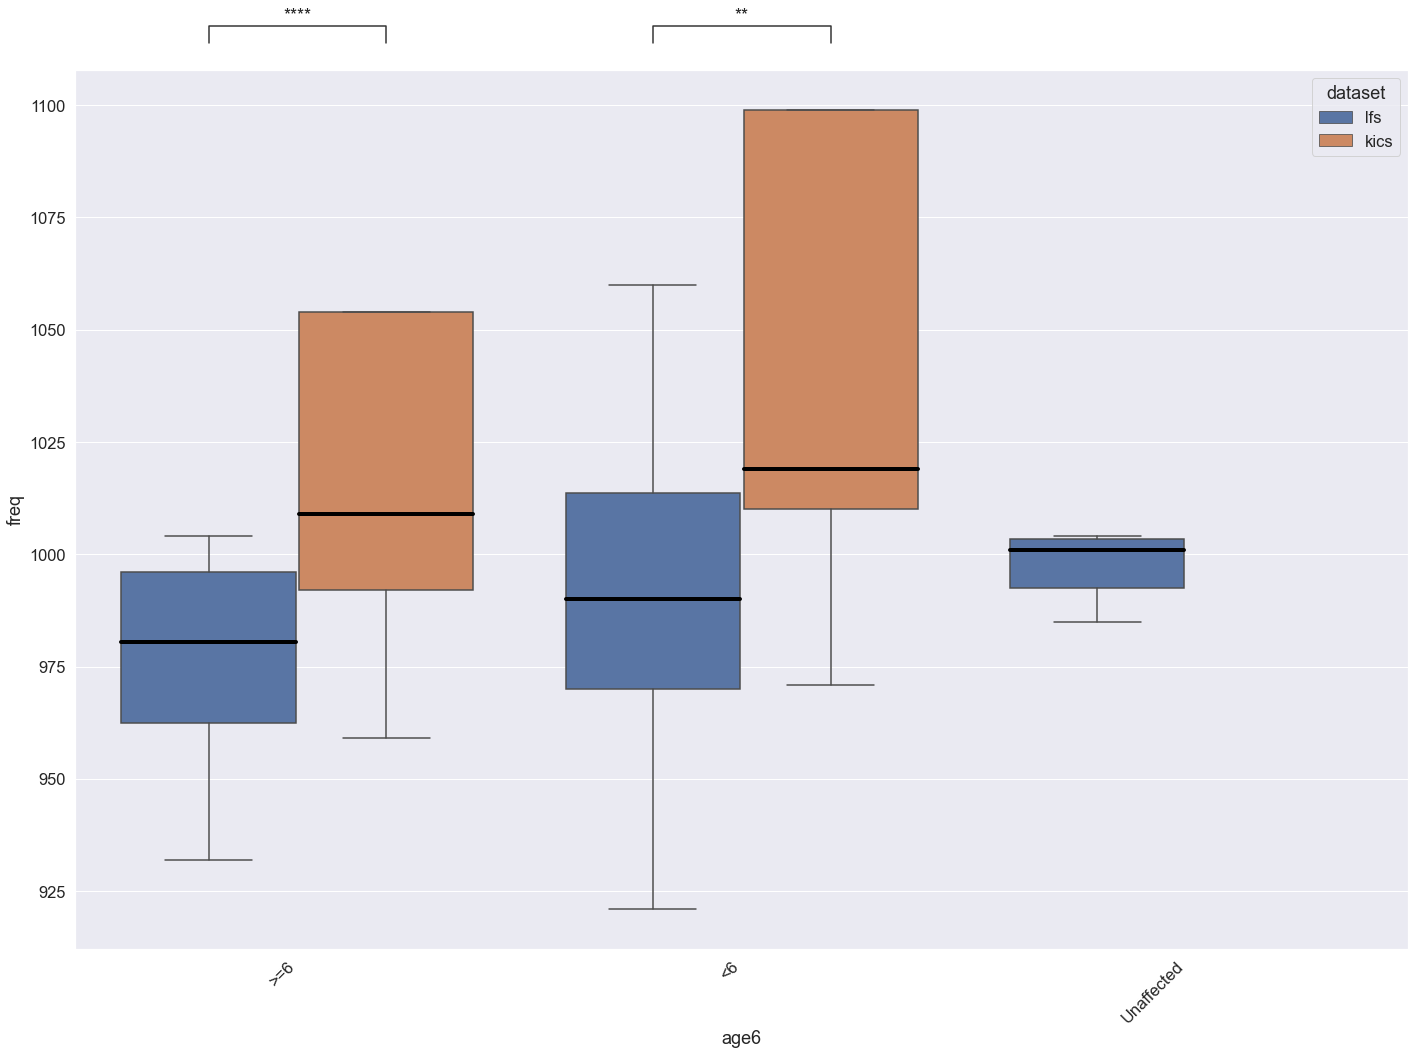

In [23]:
mergeDFs(LCAlu, LUAlu, KCAlu)

Empty DataFrame
Columns: [Samples_ID, age6, freq]
Index: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.015e-03 U_stat=1.330e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.624e-02 U_stat=1.705e+02


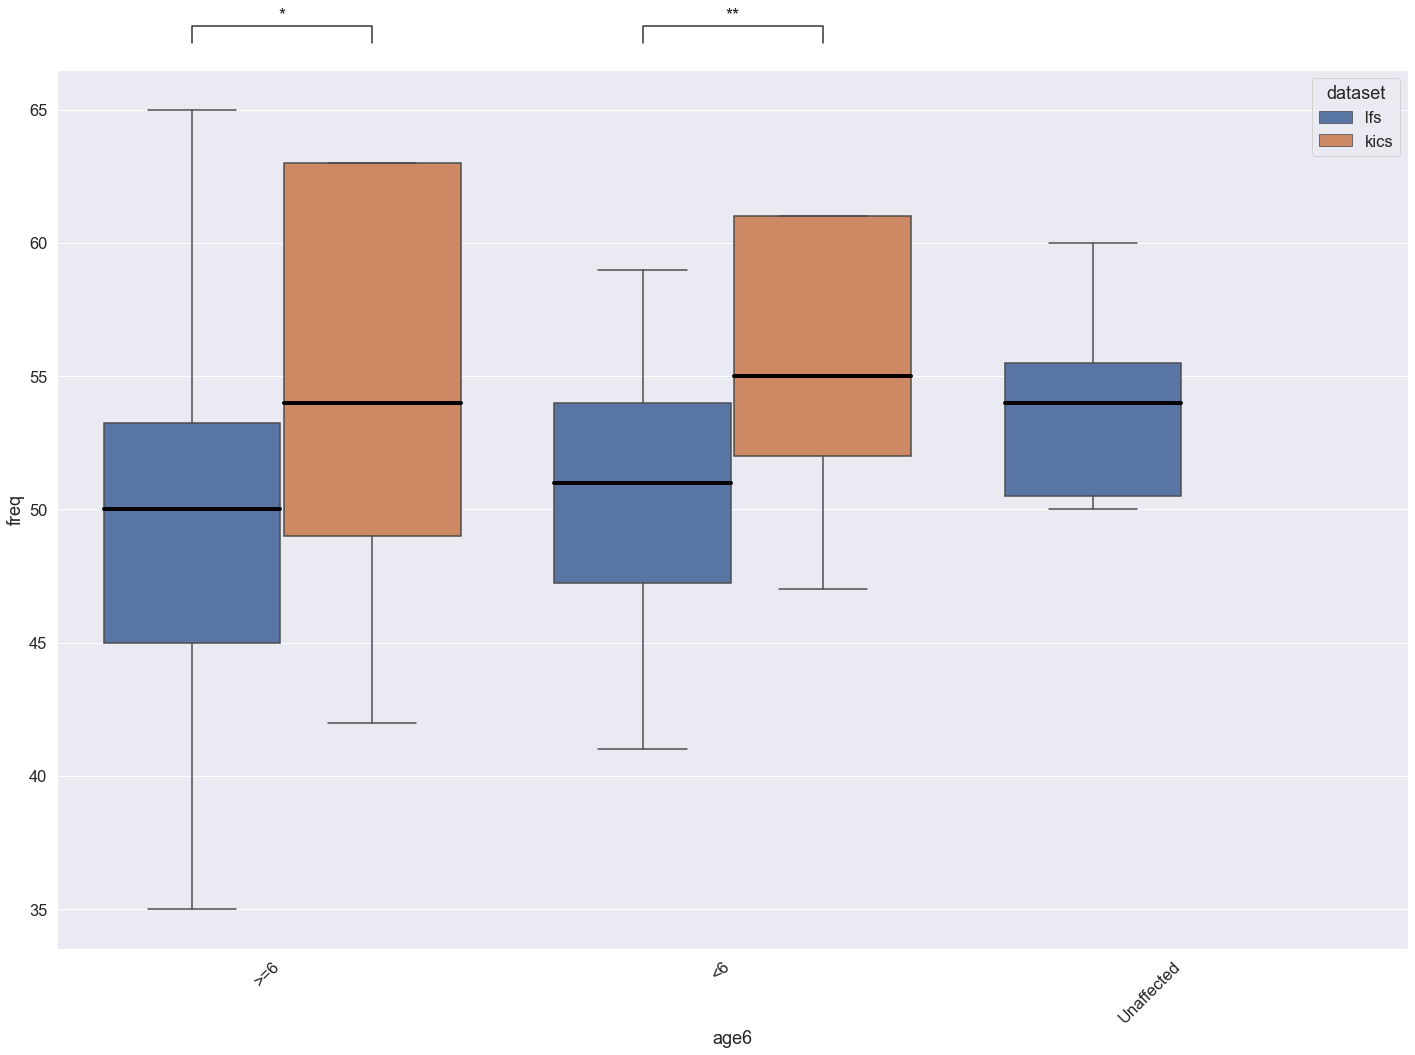

In [24]:
mergeDFs(LCLine1, LULine1, KCLine1)

Empty DataFrame
Columns: [Samples_ID, age6, freq]
Index: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.100e-01 U_stat=1.825e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.068e-01 U_stat=1.990e+02


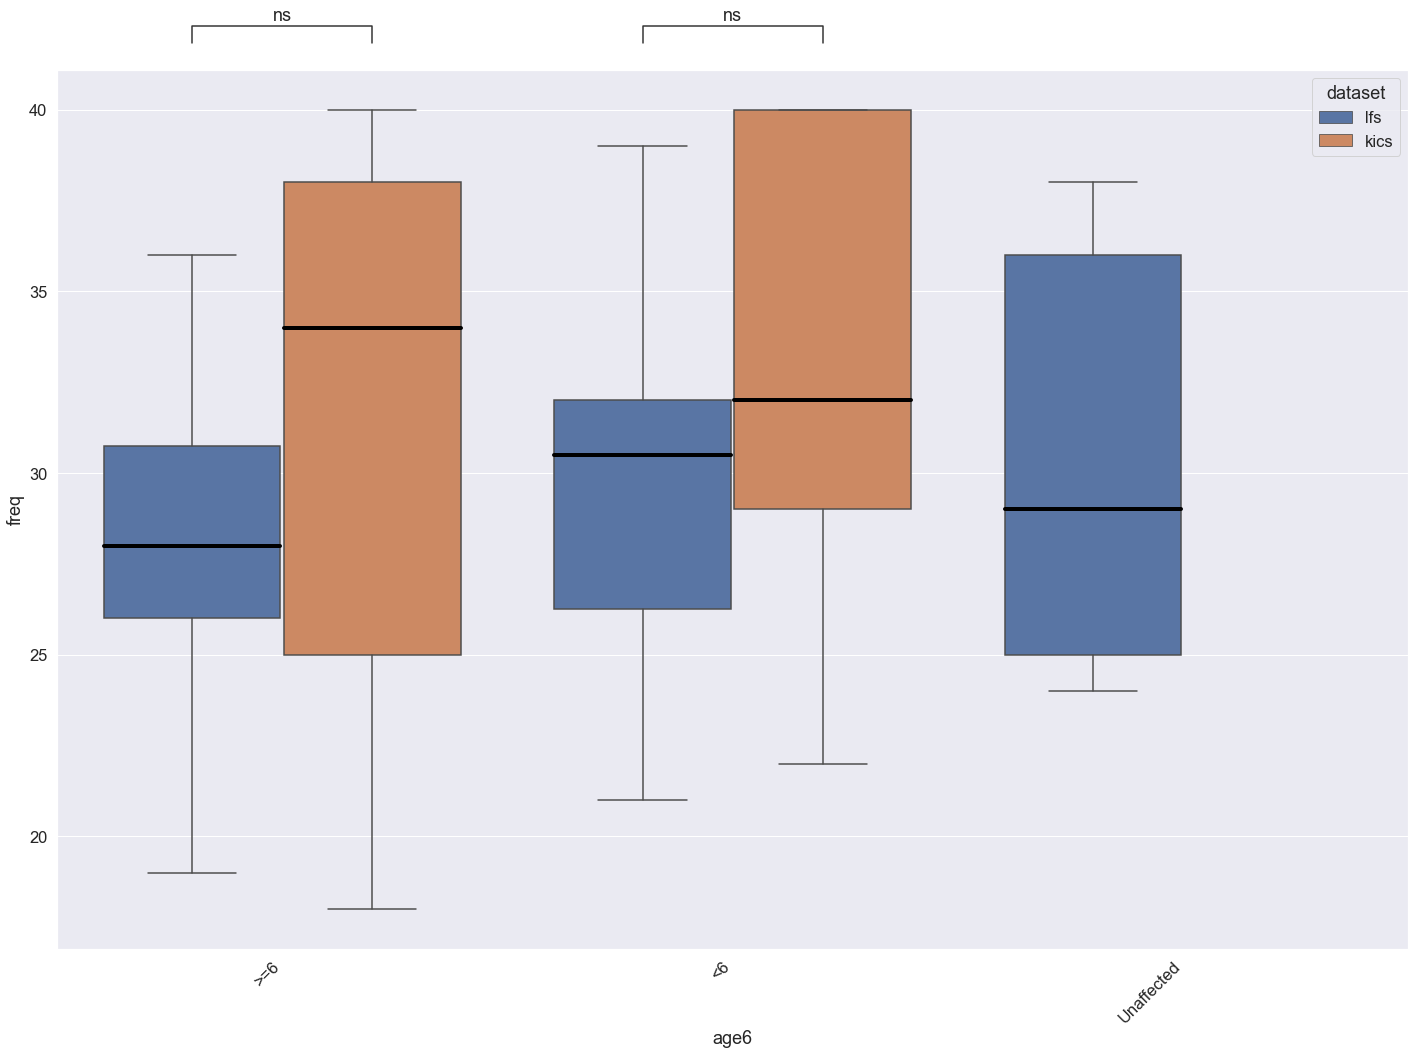

In [25]:
mergeDFs(LCSva, LUSva, KCSva)

In [26]:
def graphBoxGen(xColumnName, df, ycol = 0):
    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xColumnName, y=ycol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    #add statistical test here

#     # initializing list
#     uniqueTissue = list(df[xColumnName].unique()) 

#     #does all possible pairings given a list
#     listPairing = [(a,b) for x, a in enumerate(uniqueTissue) for b in uniqueTissue[x+1:]]
#     #print(listPairing)

#     annot = Annotator(ax, listPairing, data=df, x=xColumnName, y=ycol)
#     annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
#     annot.apply_and_annotate()

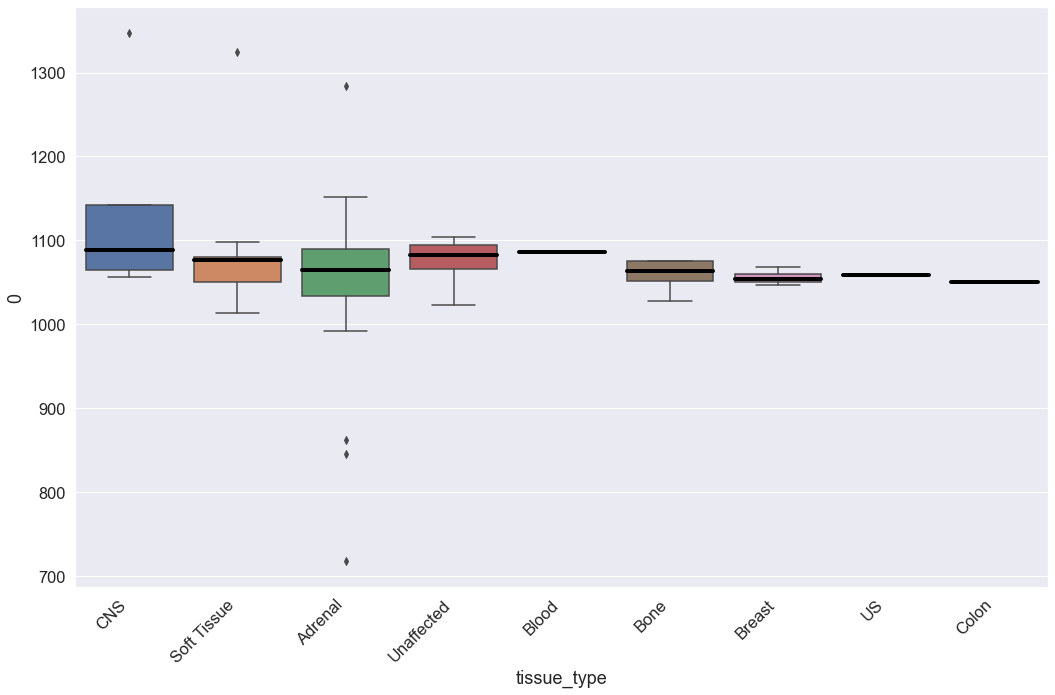

In [27]:
"""
Diagnosis and Tissue_Type inside each cohort
"""
#Overall
ldf = bigLdf.drop(['sample','SV_type', 'ageofonset'], axis=1)
kdf = bigKdf.drop(['sample','SV_type','abbv_id','ageofonset'],axis=1)

ldfGenTissue = ldf.drop(['ALT','cancer_diagnosis'],axis=1)
ldfGenTissue = ldfGenTissue.value_counts().to_frame().reset_index()

graphBoxGen('tissue_type', ldfGenTissue)

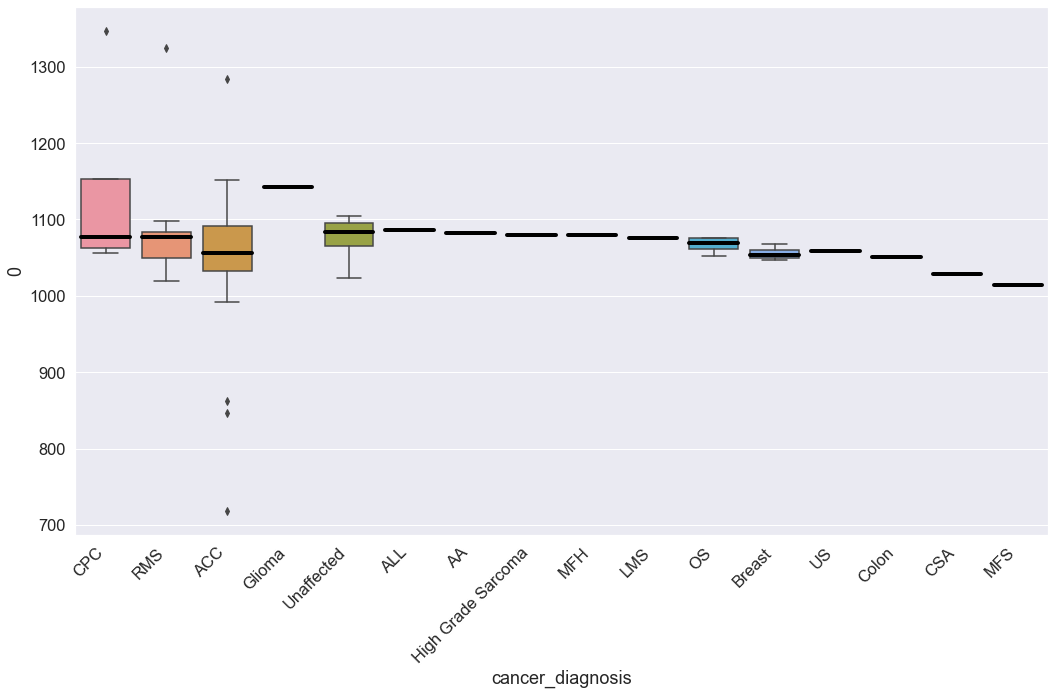

In [28]:
ldfGenDiag = ldf.drop(['ALT','tissue_type'],axis=1)
ldfGenDiag = ldfGenDiag.value_counts().to_frame().reset_index()

graphBoxGen('cancer_diagnosis', ldfGenDiag)

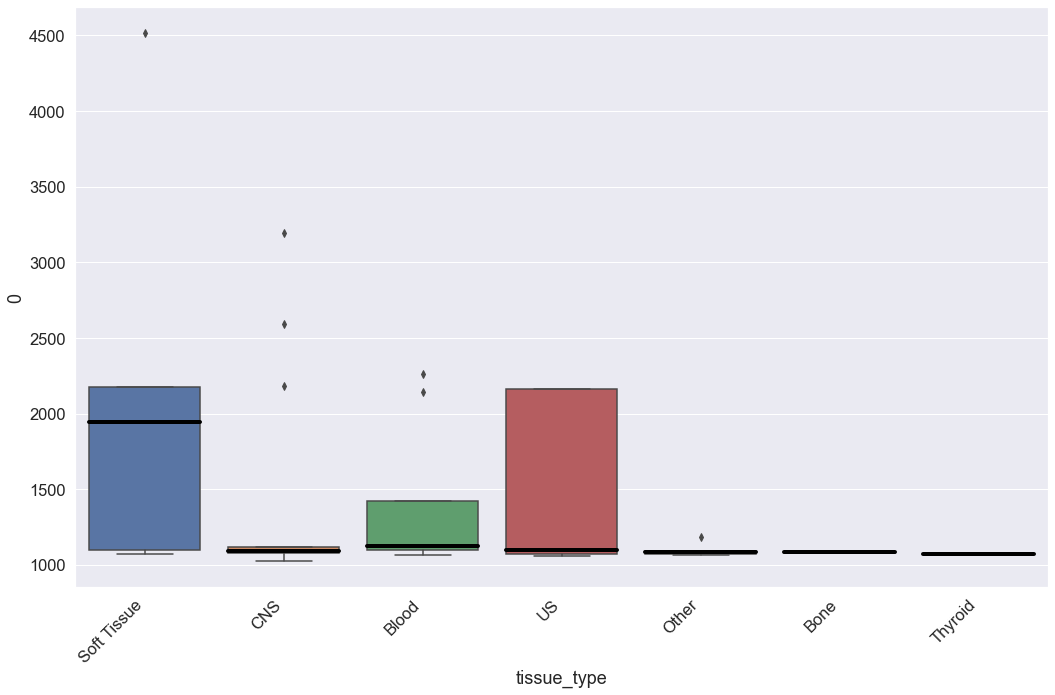

In [29]:
kdfGenTissue = kdf.drop(['ALT', 'cancer_diagnosis'], axis=1)
kdfGenTissue = kdfGenTissue.value_counts().to_frame().reset_index()
graphBoxGen('tissue_type', kdfGenTissue)

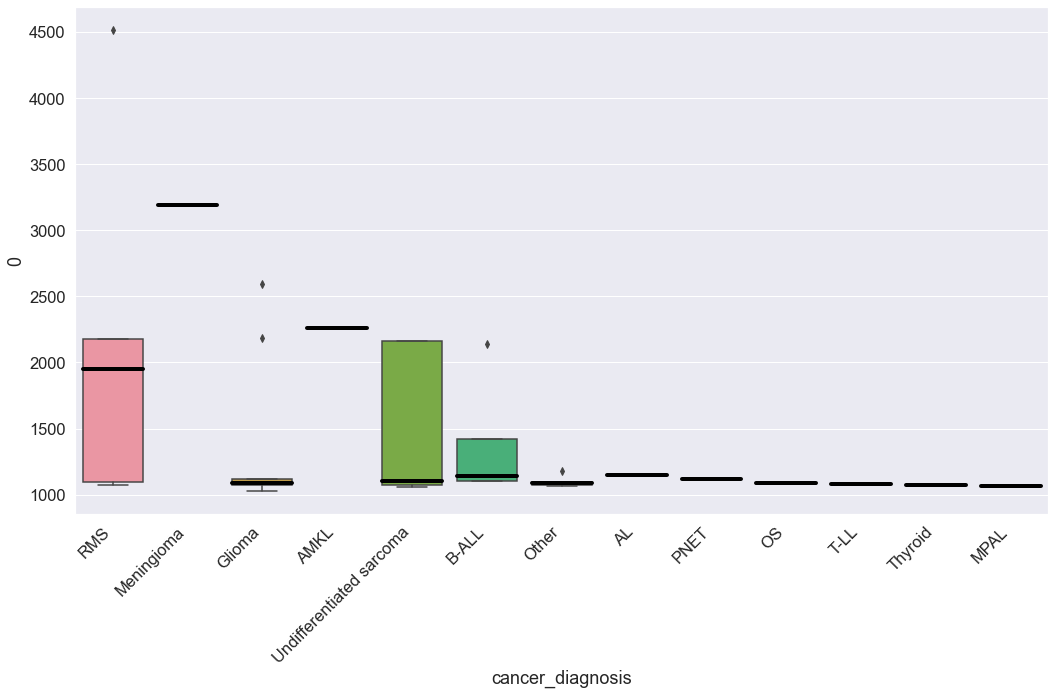

In [30]:
kdfGenDiag = kdf.drop(['ALT', 'tissue_type'], axis=1)
kdfGenDiag = kdfGenDiag.value_counts().to_frame().reset_index()
graphBoxGen('cancer_diagnosis', kdfGenDiag)

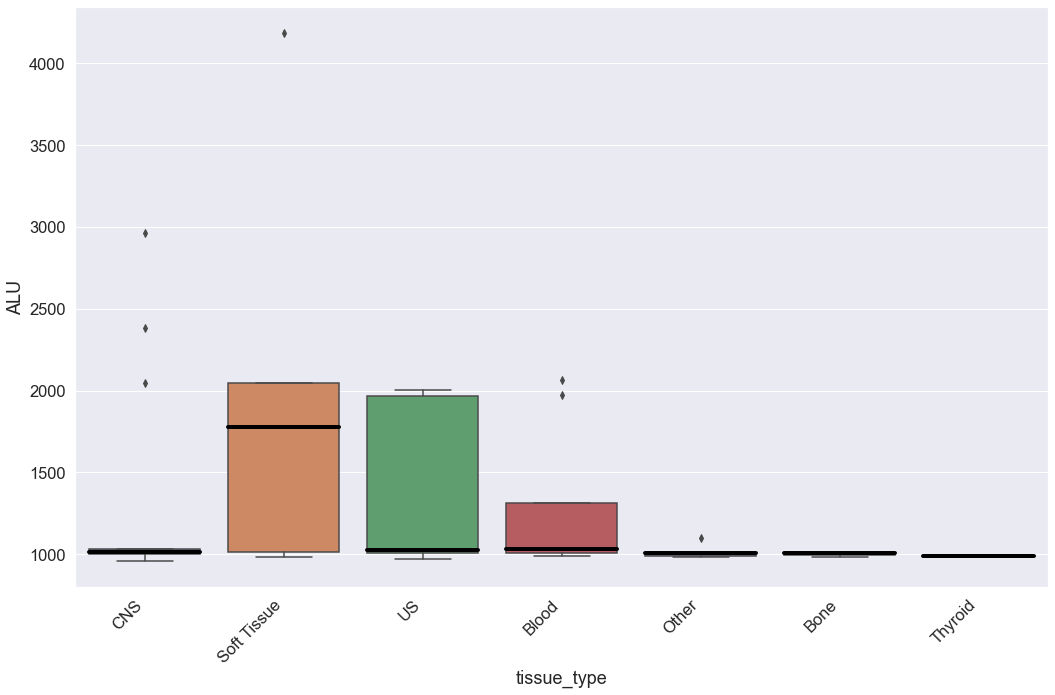

In [31]:
"""
ALT Specific (ALU LINE1 SVA) Kics then Lfs. Tissue then Diag
"""
kT = kdf.drop(['cancer_diagnosis'], axis=1).groupby(['Samples_ID', 'ALT','tissue_type']).size()
kT = kT.unstack(1)
lT = ldf.drop(['cancer_diagnosis'], axis=1).groupby(['Samples_ID', 'ALT', 'tissue_type']).size()
lT = lT.unstack(1)

kD = kdf.drop(['tissue_type'], axis=1).groupby(['Samples_ID', 'ALT','cancer_diagnosis']).size()
kD = kD.unstack(1)
lD = ldf.drop(['tissue_type'], axis=1).groupby(['Samples_ID', 'ALT','cancer_diagnosis']).size()
lD = lD.unstack(1)

graphBoxGen('tissue_type', kT.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

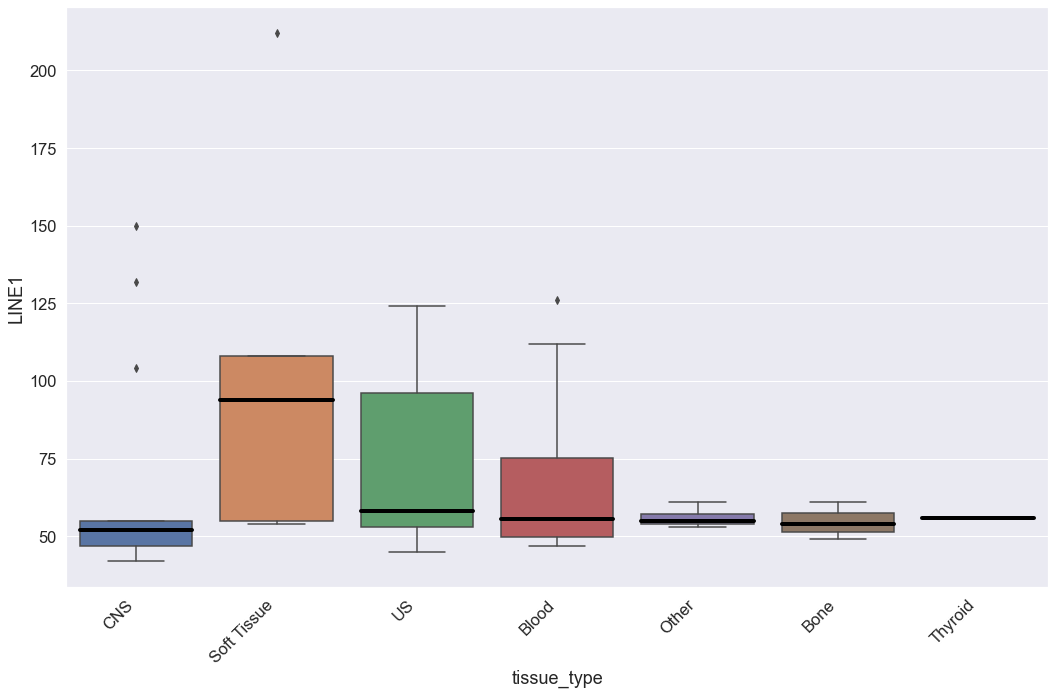

In [32]:
graphBoxGen('tissue_type', kT.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

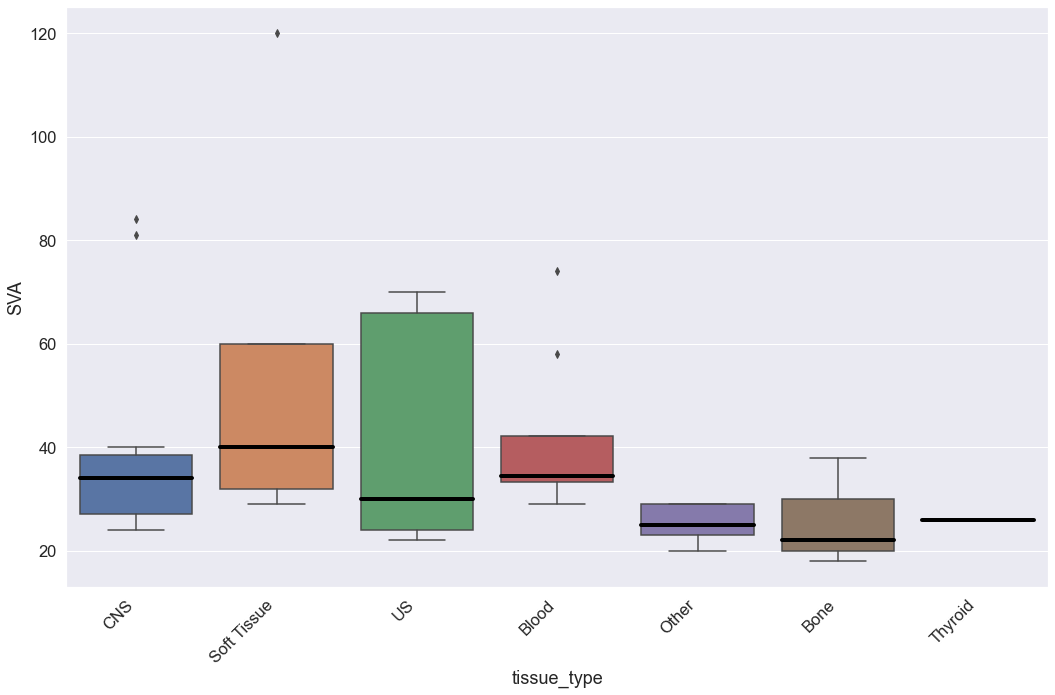

In [33]:
graphBoxGen('tissue_type', kT.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

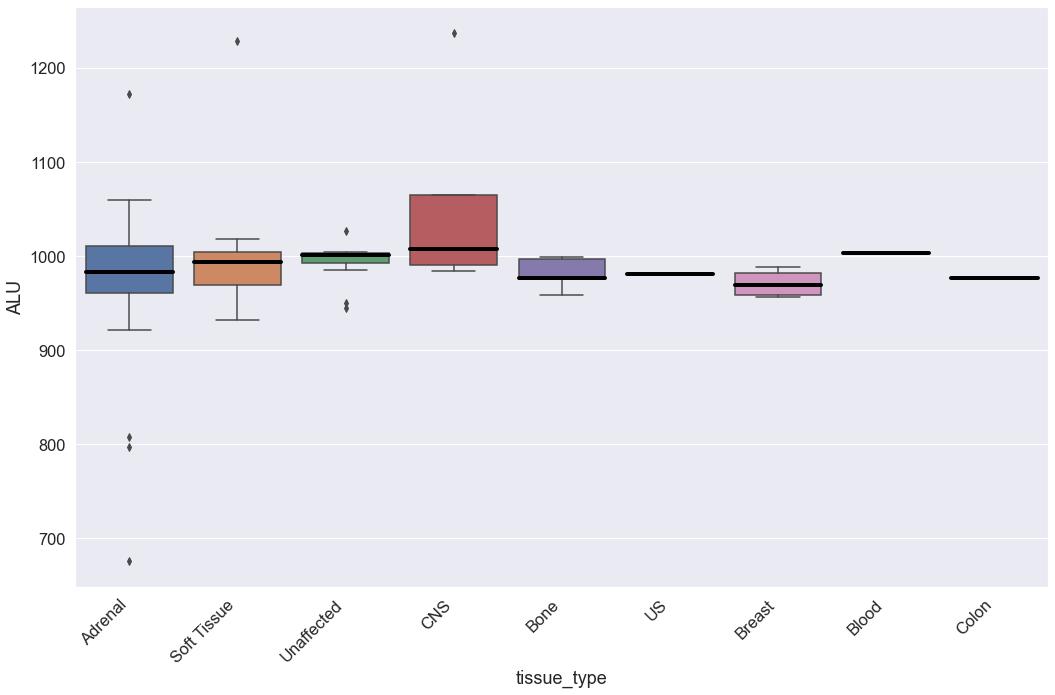

In [34]:
#lfs tissue
graphBoxGen('tissue_type', lT.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

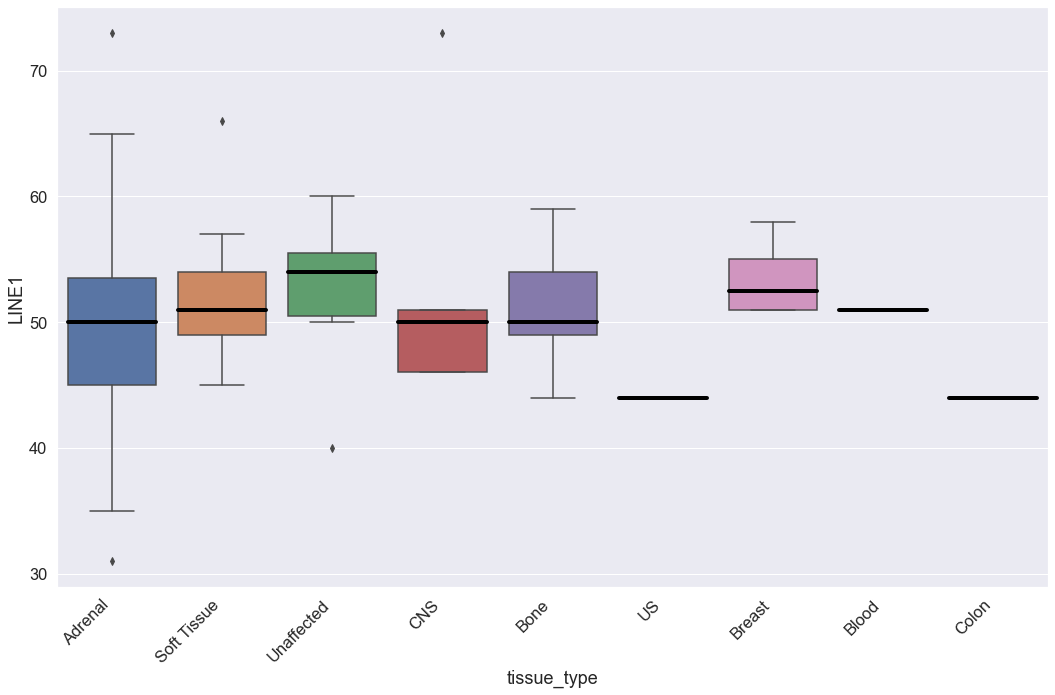

In [35]:
graphBoxGen('tissue_type', lT.drop(['SVA', 'ALU'], axis=1).reset_index(),'LINE1')

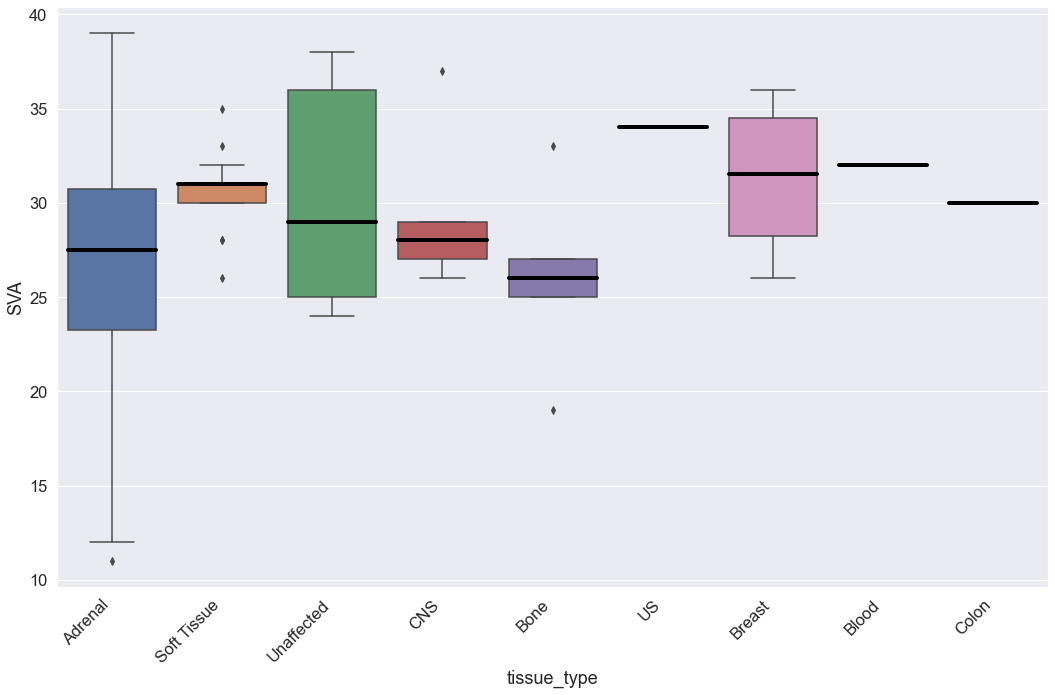

In [36]:
graphBoxGen('tissue_type', lT.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

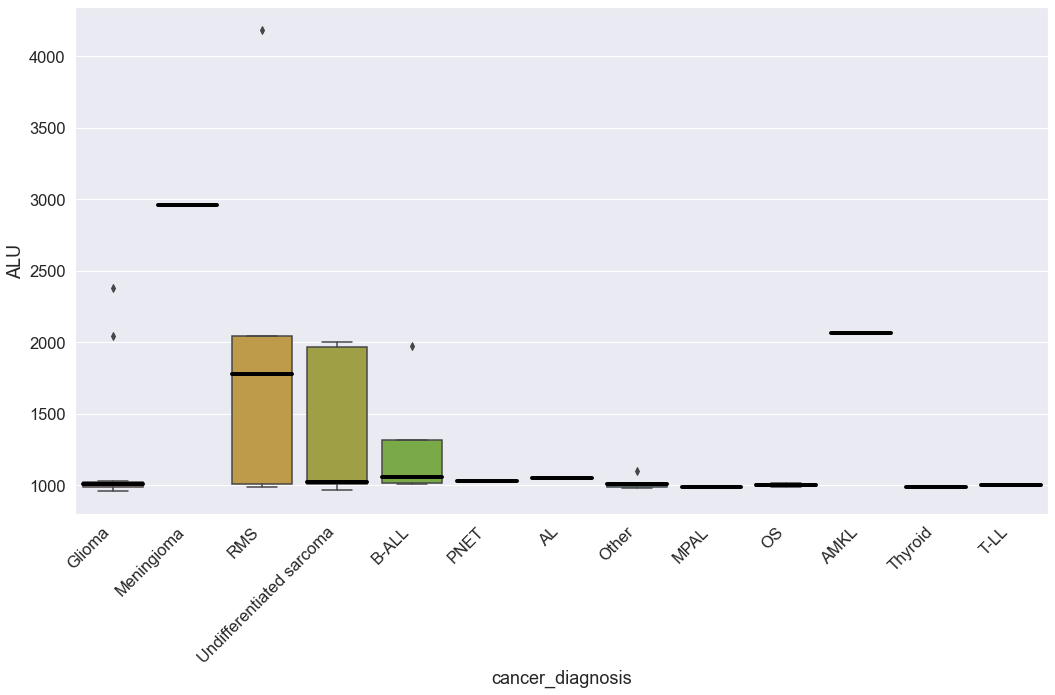

In [37]:
#kics Diagnosis
graphBoxGen('cancer_diagnosis', kD.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

# HERE WE IS STUCK

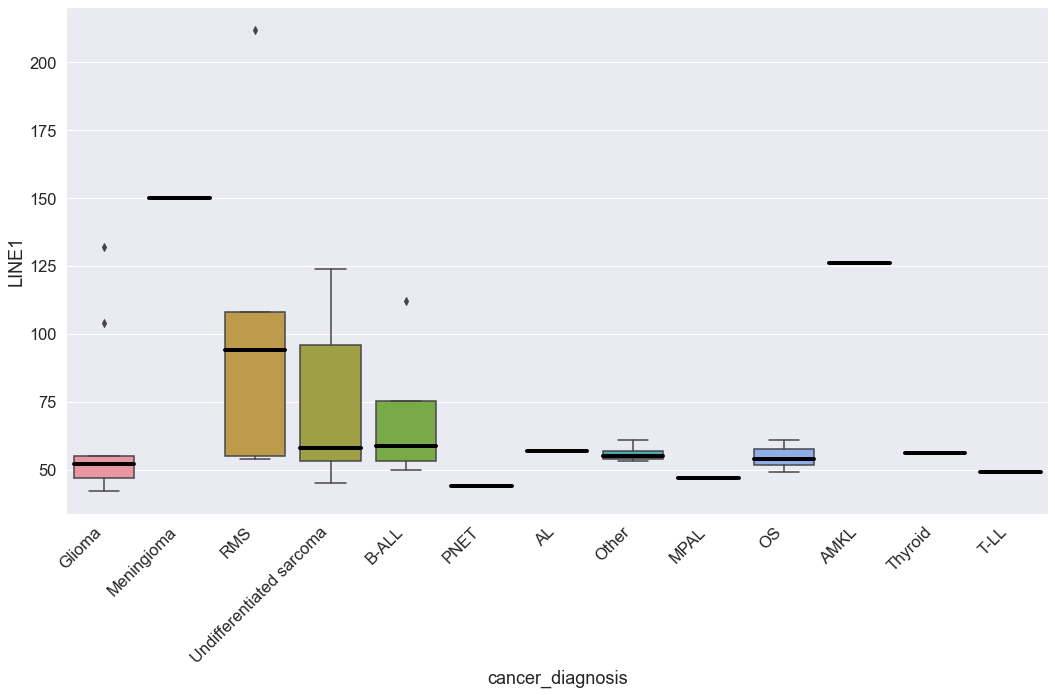

In [38]:
graphBoxGen('cancer_diagnosis', kD.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

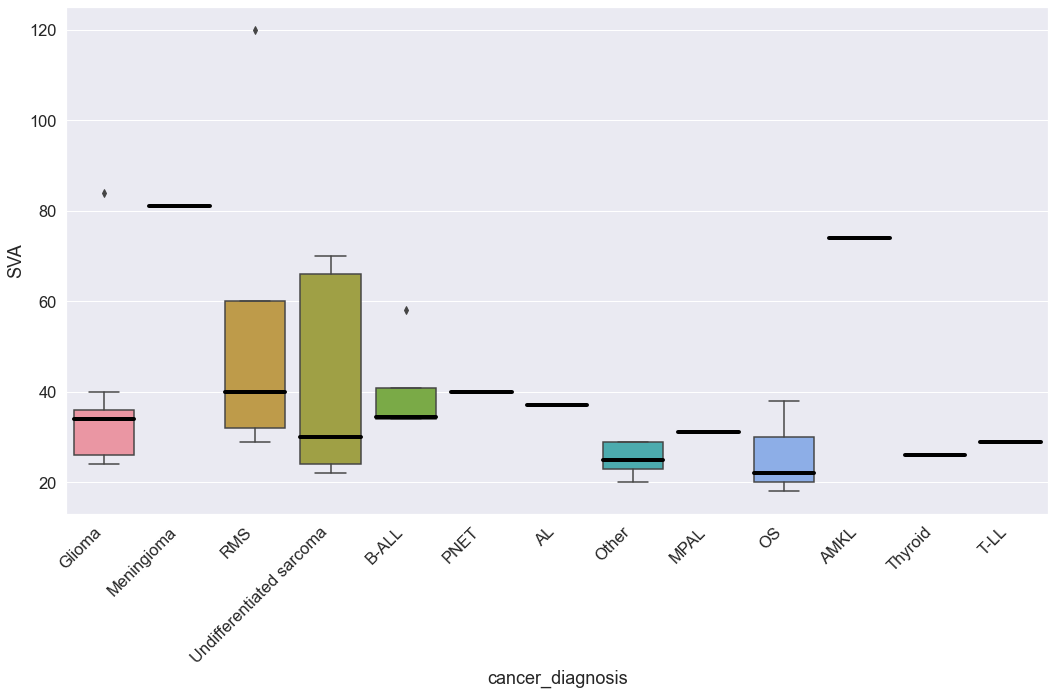

In [39]:
graphBoxGen('cancer_diagnosis', kD.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

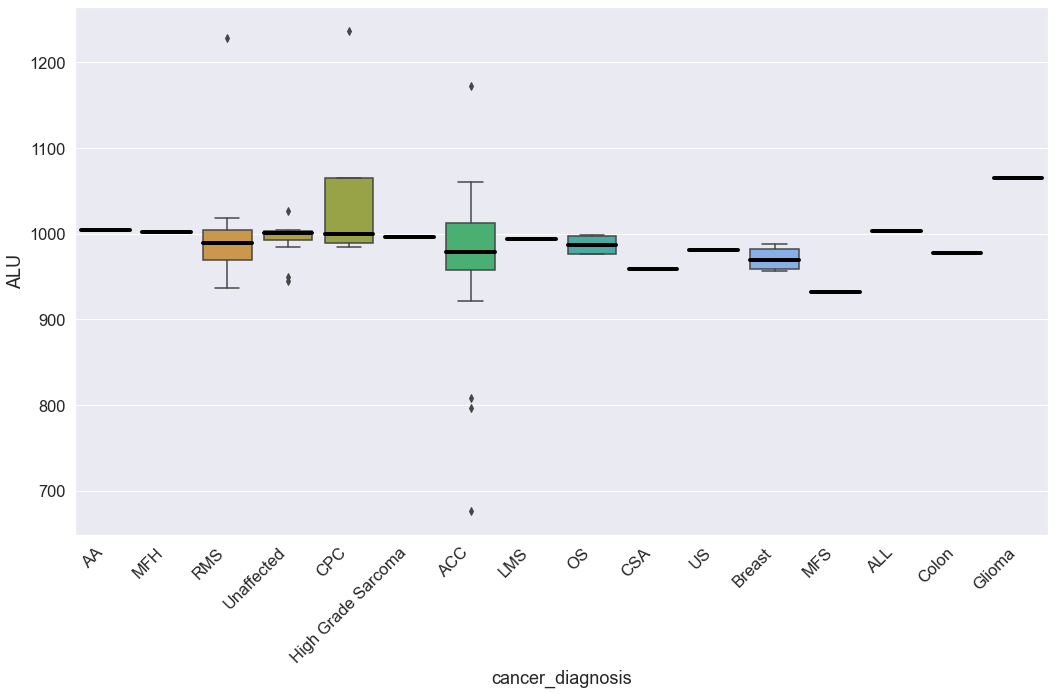

In [40]:
graphBoxGen('cancer_diagnosis', lD.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

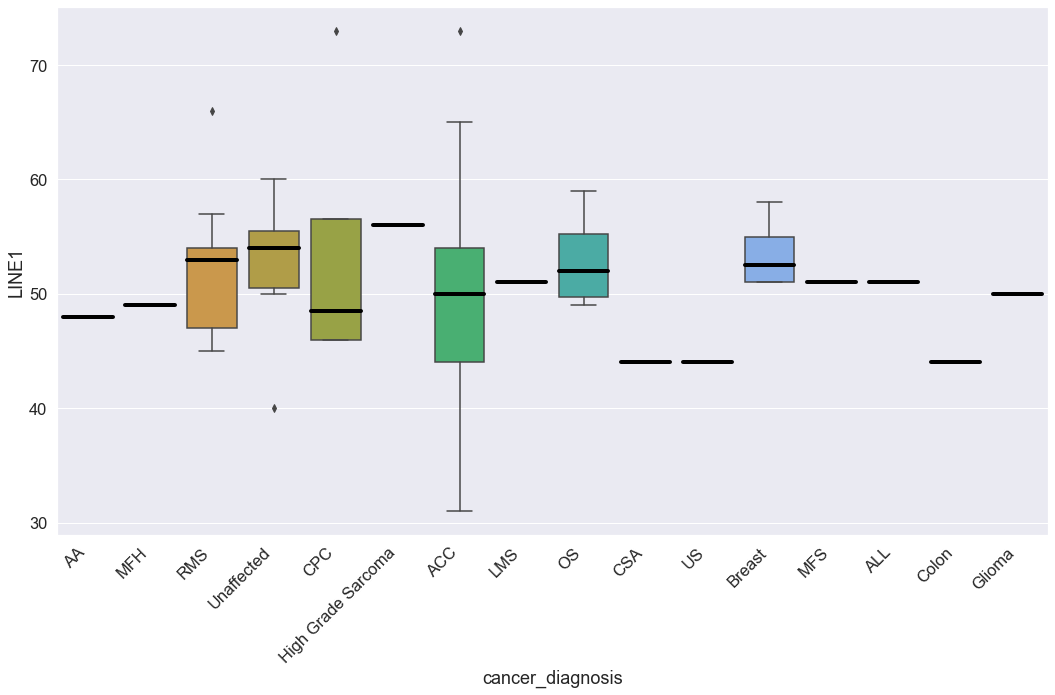

In [41]:
graphBoxGen('cancer_diagnosis', lD.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

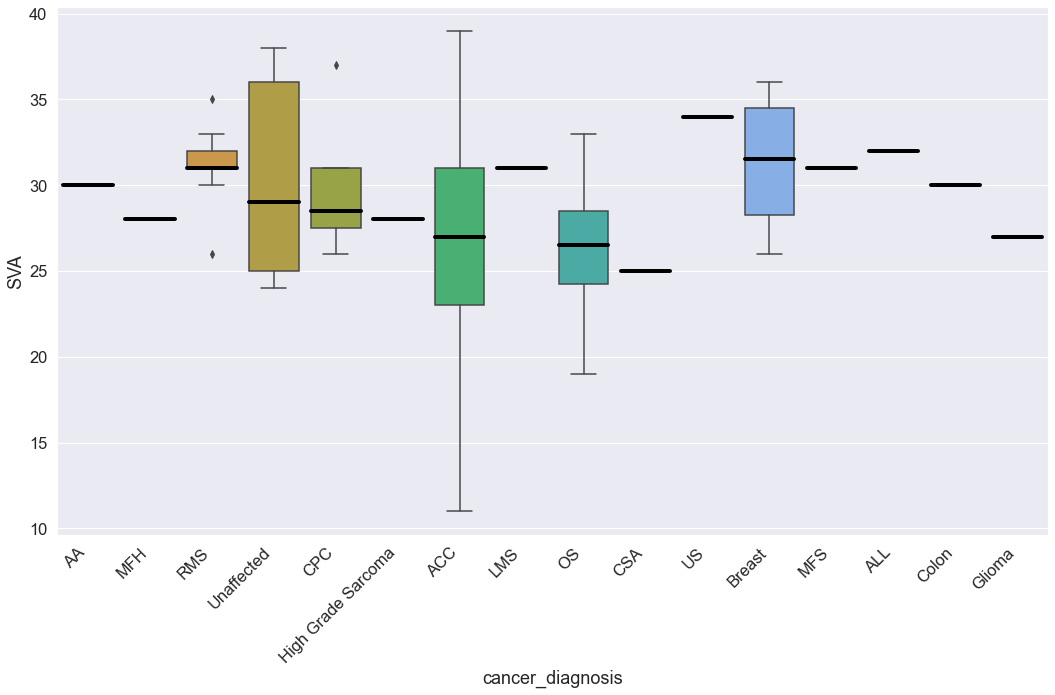

In [42]:
graphBoxGen('cancer_diagnosis', lD.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

MannwhitneyuResult(statistic=342.0, pvalue=0.31478944723278646)


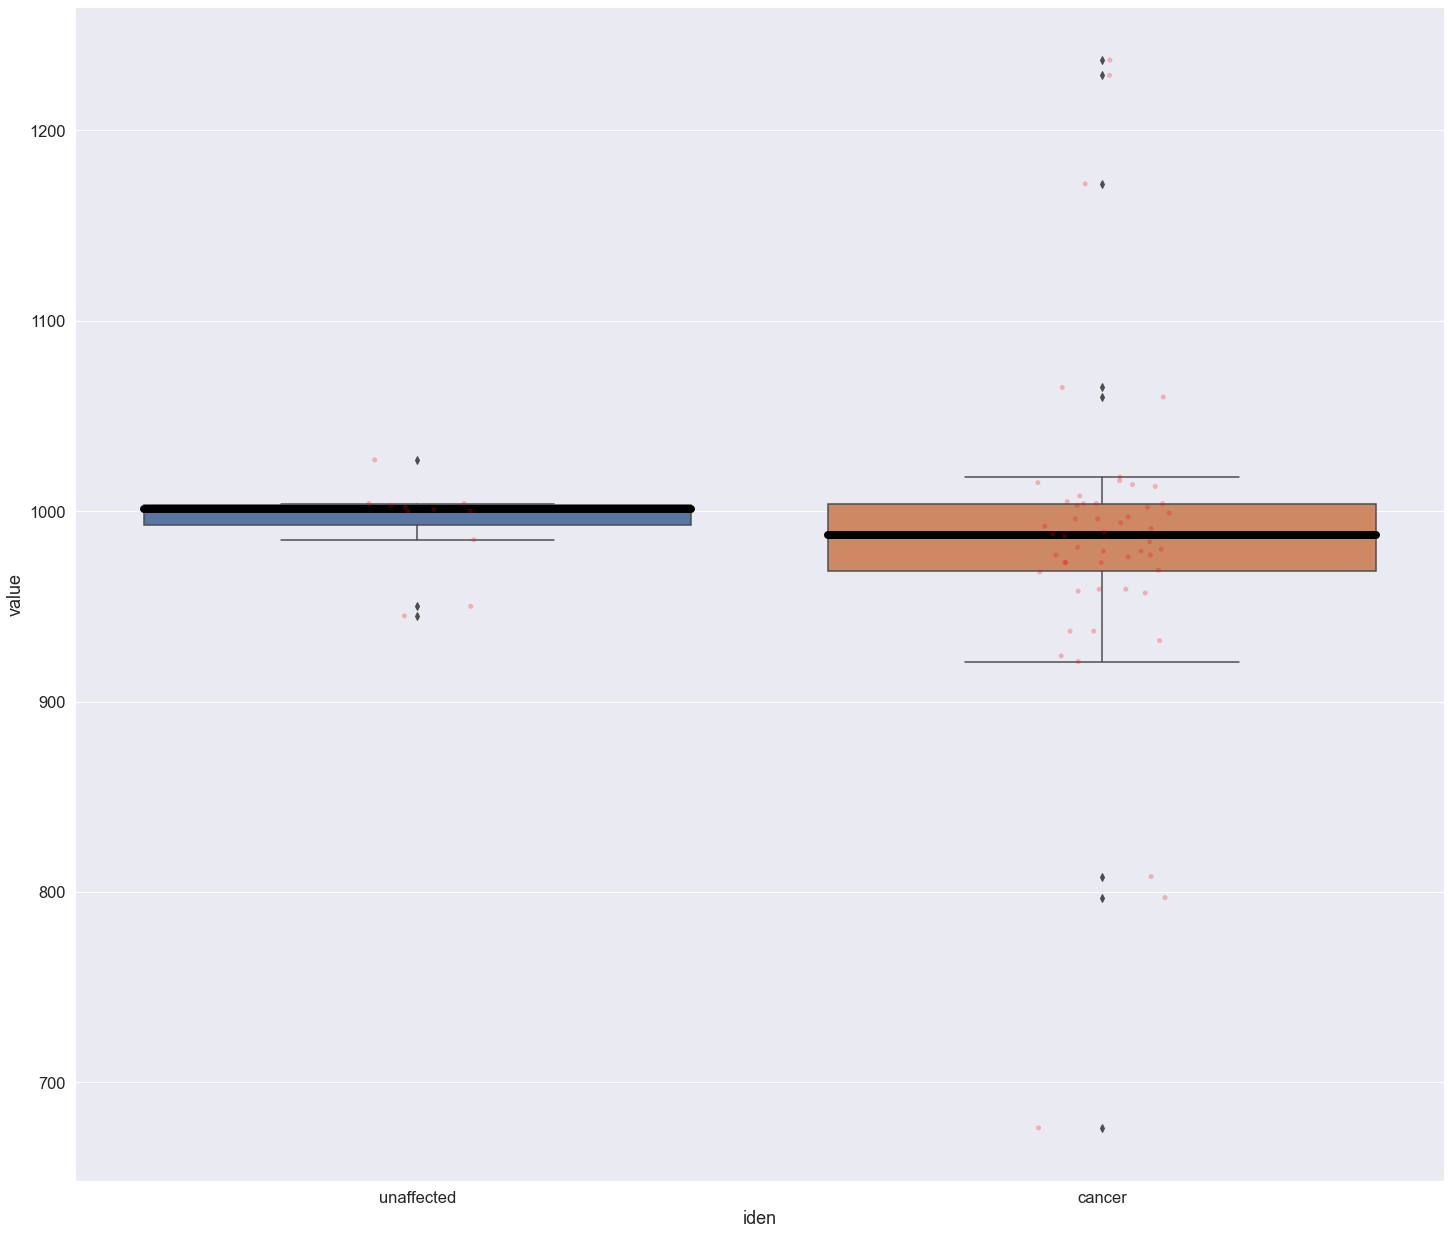

MannwhitneyuResult(statistic=367.5, pvalue=0.1410915439773128)


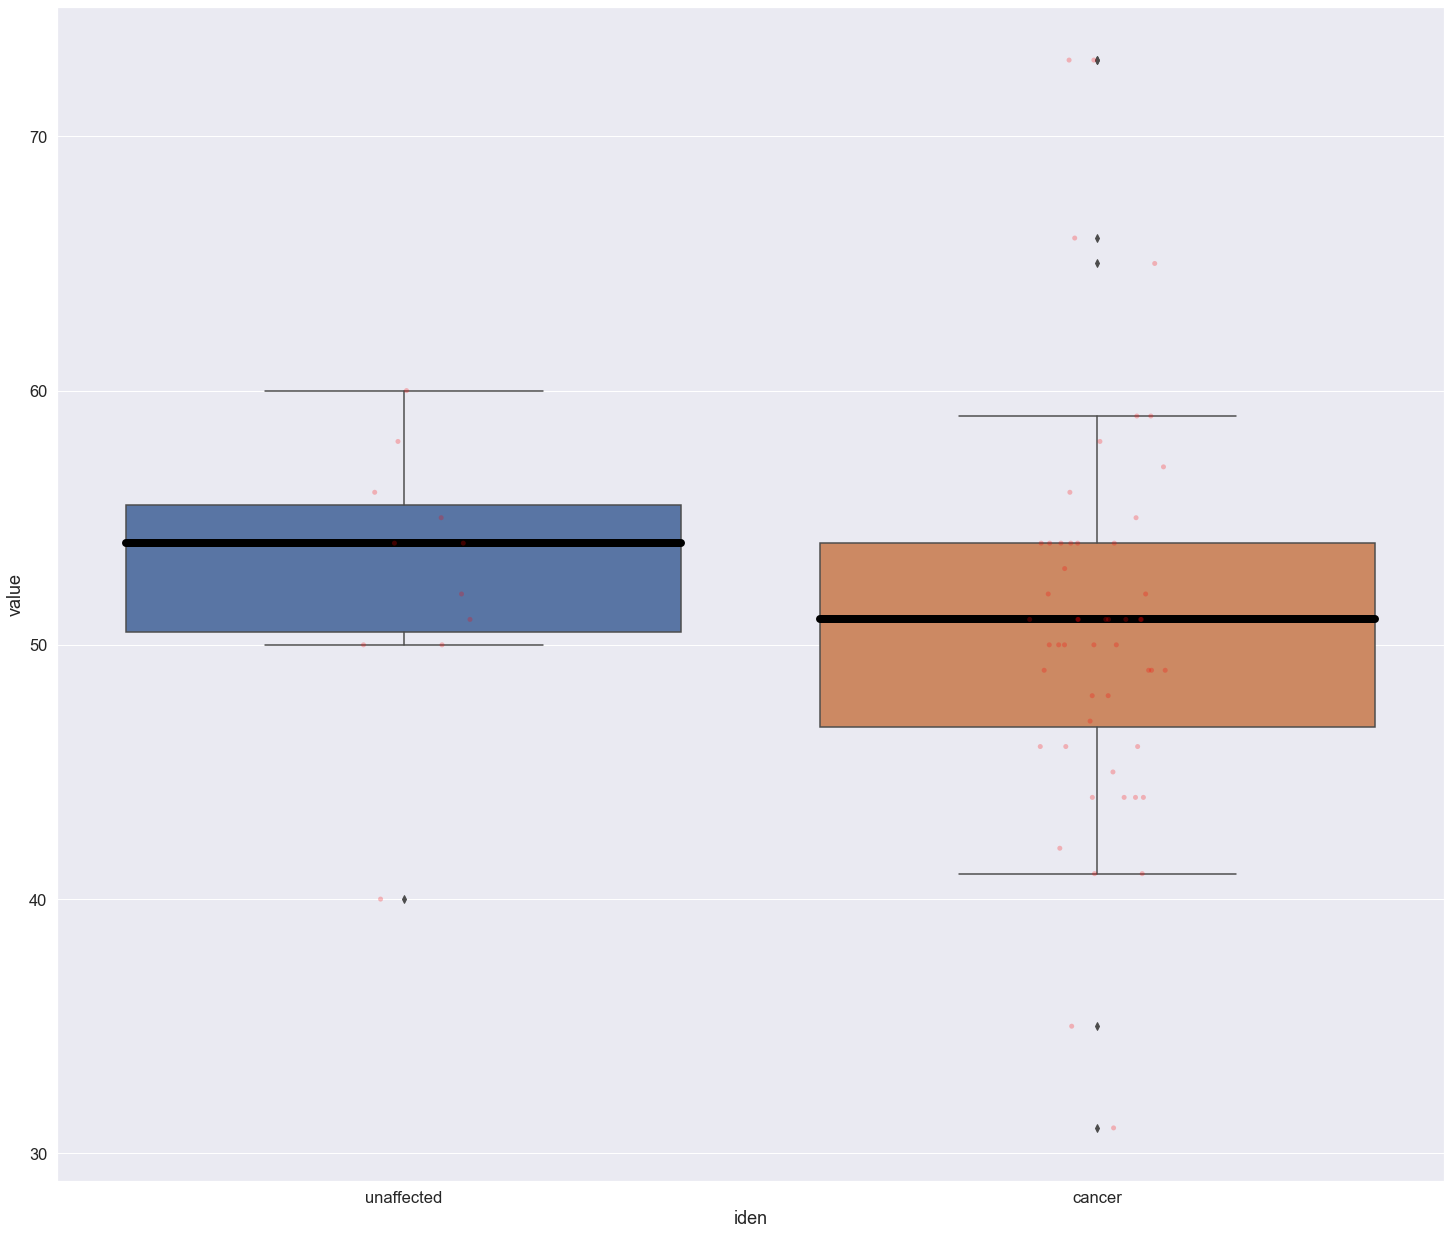

MannwhitneyuResult(statistic=298.5, pvalue=0.8274816180334266)


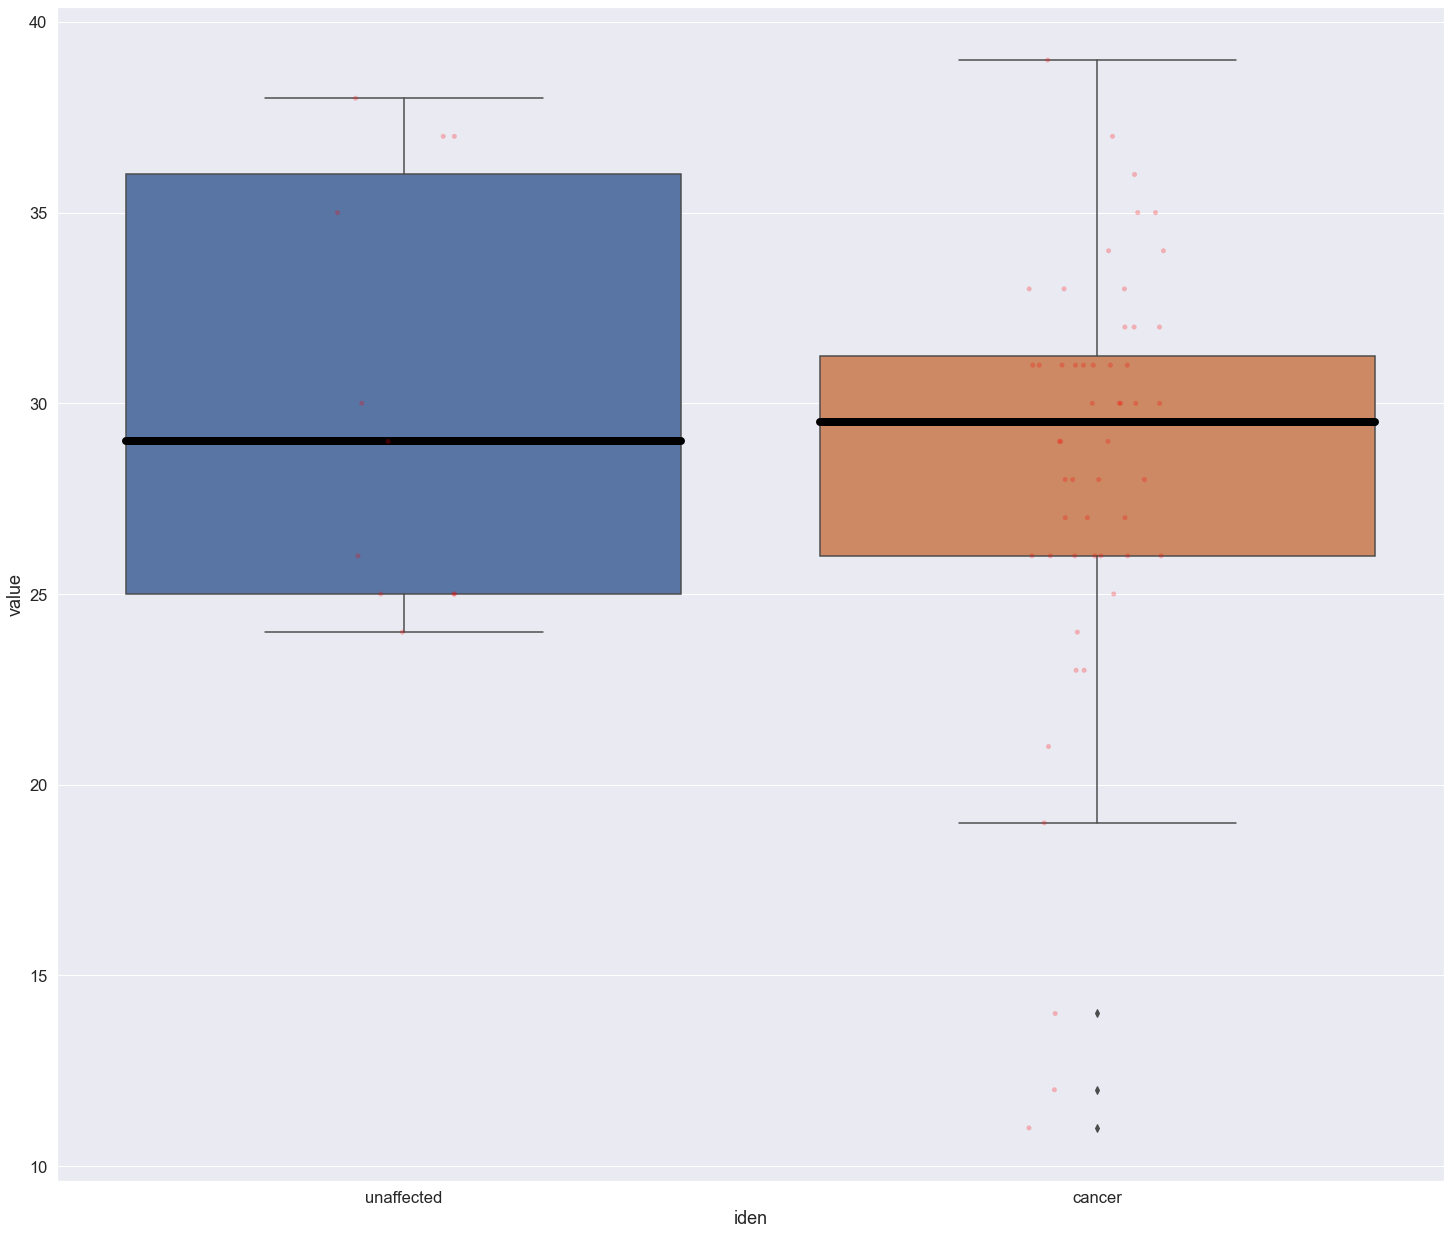

MannwhitneyuResult(statistic=369.5, pvalue=0.13283911046991184)


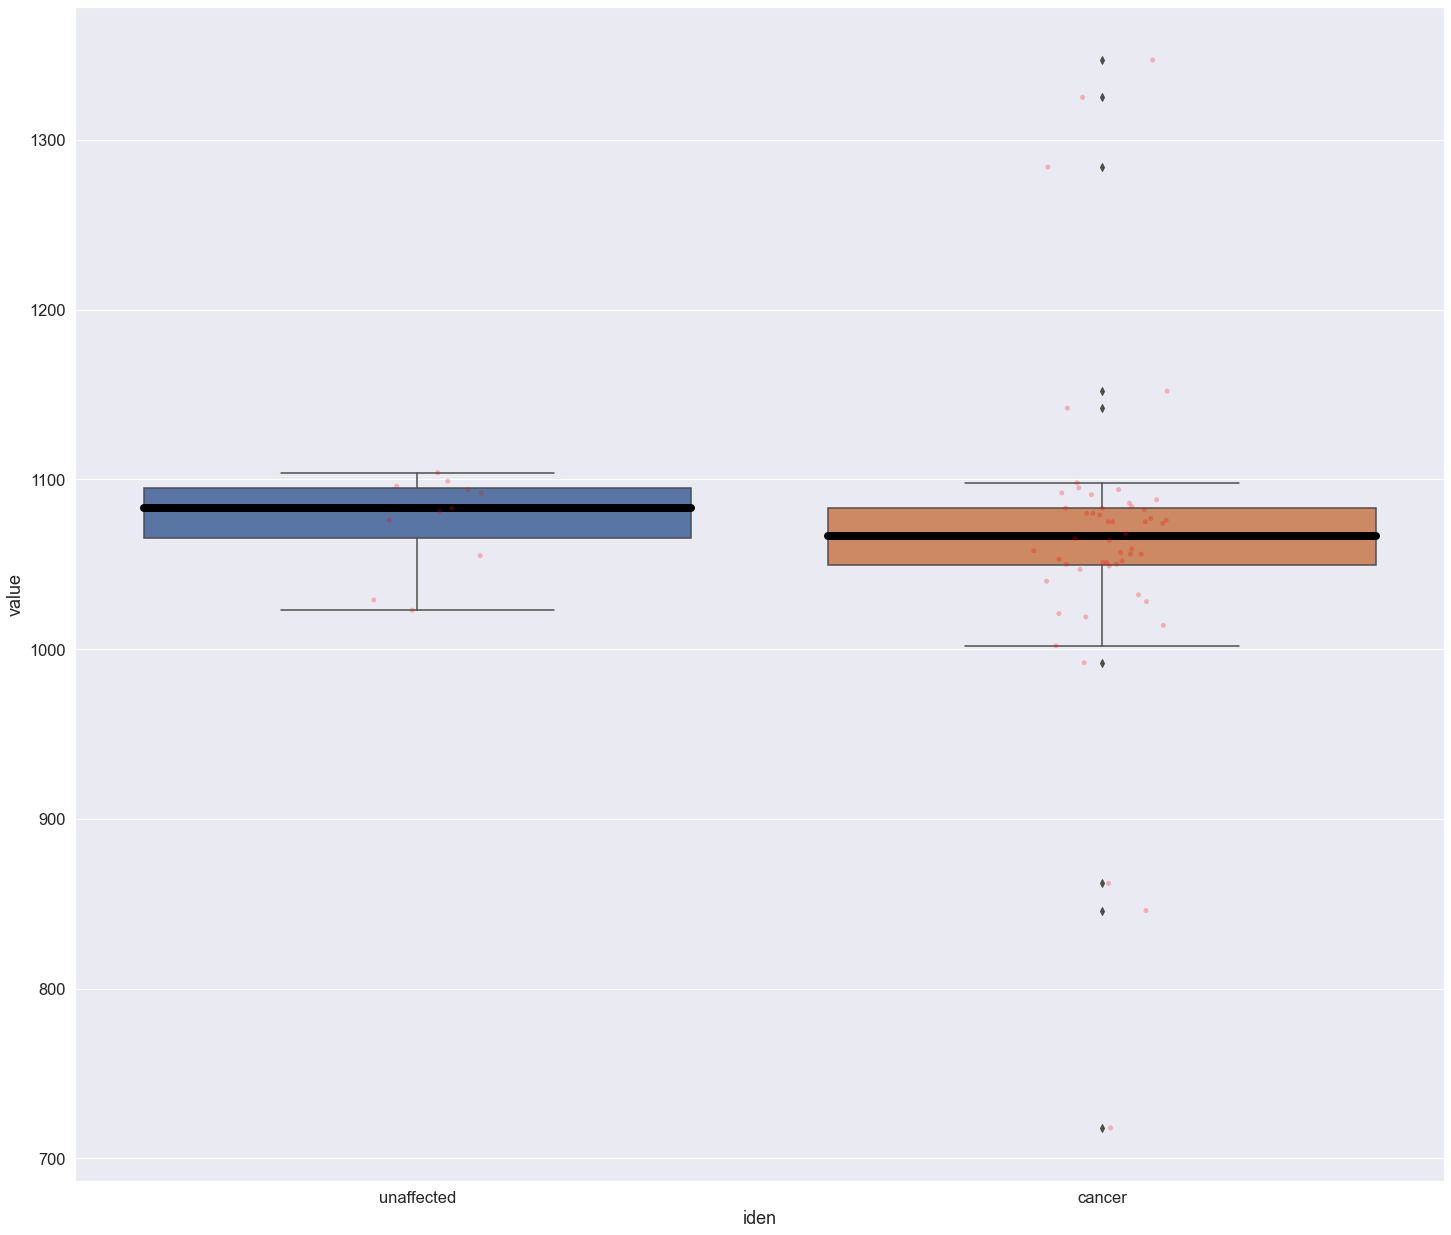

In [43]:
"""
LFS vs Unaffected
3 Big graphs for TE elements ALU LINE1 SVA
"""
#check if unaffected tissue type is unaffected diag and vice versa -> they are
# print(bigLdf.head(20))
# print(bigLdf['tissue_type'].unique())
# tempUnaffectedT = bigLdf[bigLdf['tissue_type']=='Unaffected']
# tempUnaffectedD = bigLdf[bigLdf['cancer_diagnosis']=='Unaffected']
# print(tempUnaffectedT['Samples_ID'].unique())
# print(tempUnaffectedT['cancer_diagnosis'].unique())
# print(tempUnaffectedD['Samples_ID'].unique())
# print(tempUnaffectedD['cancer_diagnosis'].unique())


unaffectedDf = bigLdf[bigLdf['tissue_type']=='Unaffected'].drop(['sample', 'tissue_type',
                                                                 'cancer_diagnosis','SV_type','ageofonset'], axis=1)
cancerDf = bigLdf[bigLdf['tissue_type']!='Unaffected'].drop(['sample', 'tissue_type',
                                                                 'cancer_diagnosis','SV_type','ageofonset'], axis=1)
uAll = unaffectedDf.drop(['ALT'],axis=1).value_counts().to_frame().reset_index()
cAll = cancerDf.drop(['ALT'],axis=1).value_counts().to_frame().reset_index()
mergedAll = pd.DataFrame(data={'unaffected':uAll[0], 'cancer':cAll[0]})

uAlu = unaffectedDf[unaffectedDf['ALT'] == 'ALU'].value_counts().to_frame().reset_index()
cAlu = cancerDf[cancerDf['ALT'] == 'ALU'].value_counts().to_frame().reset_index()
mergedAlu = pd.DataFrame(data = {'unaffected':uAlu[0],'cancer':cAlu[0]})

uLine = unaffectedDf[unaffectedDf['ALT'] == 'LINE1'].value_counts().to_frame().reset_index()
cLine = cancerDf[cancerDf['ALT'] == 'LINE1'].value_counts().to_frame().reset_index()
mergedLine = pd.DataFrame(data = {'unaffected':uLine[0],'cancer':cLine[0]})

uSva = unaffectedDf[unaffectedDf['ALT'] == 'SVA'].value_counts().to_frame().reset_index()
cSva = cancerDf[cancerDf['ALT'] == 'SVA'].value_counts().to_frame().reset_index()
mergedSva = pd.DataFrame(data = {'unaffected':uSva[0],'cancer':cSva[0]})

#print(mergedInv)
title = ['unaffected','cancer']

boxplotPoints(title, title, mergedAlu)
boxplotPoints(title, title, mergedLine)
boxplotPoints(title, title, mergedSva)
boxplotPoints(title, title, mergedAll)


In [44]:
"""
LFS vs Kics for Diagnosis and Tissue type. Overall and TE specific
"""

def graphSVTissue(kdf, ldf, uniqueList, isTissue):
    if isTissue:
        var = 'tissue_type'

    else:
        var = 'cancer_diagnosis'
    
    kdf = kdf.drop(['ALT'], axis=1)
    kdf = kdf.groupby(['Samples_ID']).value_counts()
    kdf = kdf.to_frame().reset_index()

    kdf.rename(columns = {0:'freq'}, inplace = True)
    
    #print the outlier!
    print(kdf.loc[kdf['freq'] > 4000])
    
    
    kdf = pd.melt(kdf, id_vars=[var], value_vars=['freq'])
    kdf['dataset'] = 'kics'
    
    

    ldf = ldf.drop(['ALT'], axis=1)
    ldf = ldf.groupby(['Samples_ID']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = pd.melt(ldf, id_vars=[var], value_vars=['freq'])
    ldf['dataset'] = 'lfs'

    mergedDf = pd.concat([ldf, kdf])
    #print(mergedDf.head(50))
    
    BoxGraphMultii(mergedDf, var, 'value', 'dataset', uniqueList) 

In [45]:
kDiagList = pd.DataFrame(data={'diag':bigKdf['cancer_diagnosis'], 'id':bigKdf['Samples_ID']}) 
lDiagList = pd.DataFrame(data={'diag':bigLdf['cancer_diagnosis'], 'id':bigLdf['Samples_ID']})
uniqueDiag = list(set(list(kDiagList['diag'].unique())+list(lDiagList['diag'].unique())))

ktList = pd.DataFrame(data={'tissue_type':bigKdf['tissue_type'], 'id':bigKdf['Samples_ID']})
ltList = pd.DataFrame(data={'tissue_type':bigLdf['tissue_type'], 'id':bigLdf['Samples_ID']})
uniqueTissue = list(set(list(ktList['tissue_type'].unique())+list(ltList['tissue_type'].unique())))

  Samples_ID cancer_diagnosis  freq
6     284386              RMS  4516
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.200e-01 U_stat=1.100e+01
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.975e-02 U_stat=0.000e+00
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.196e-02 U_stat=7.000e+00


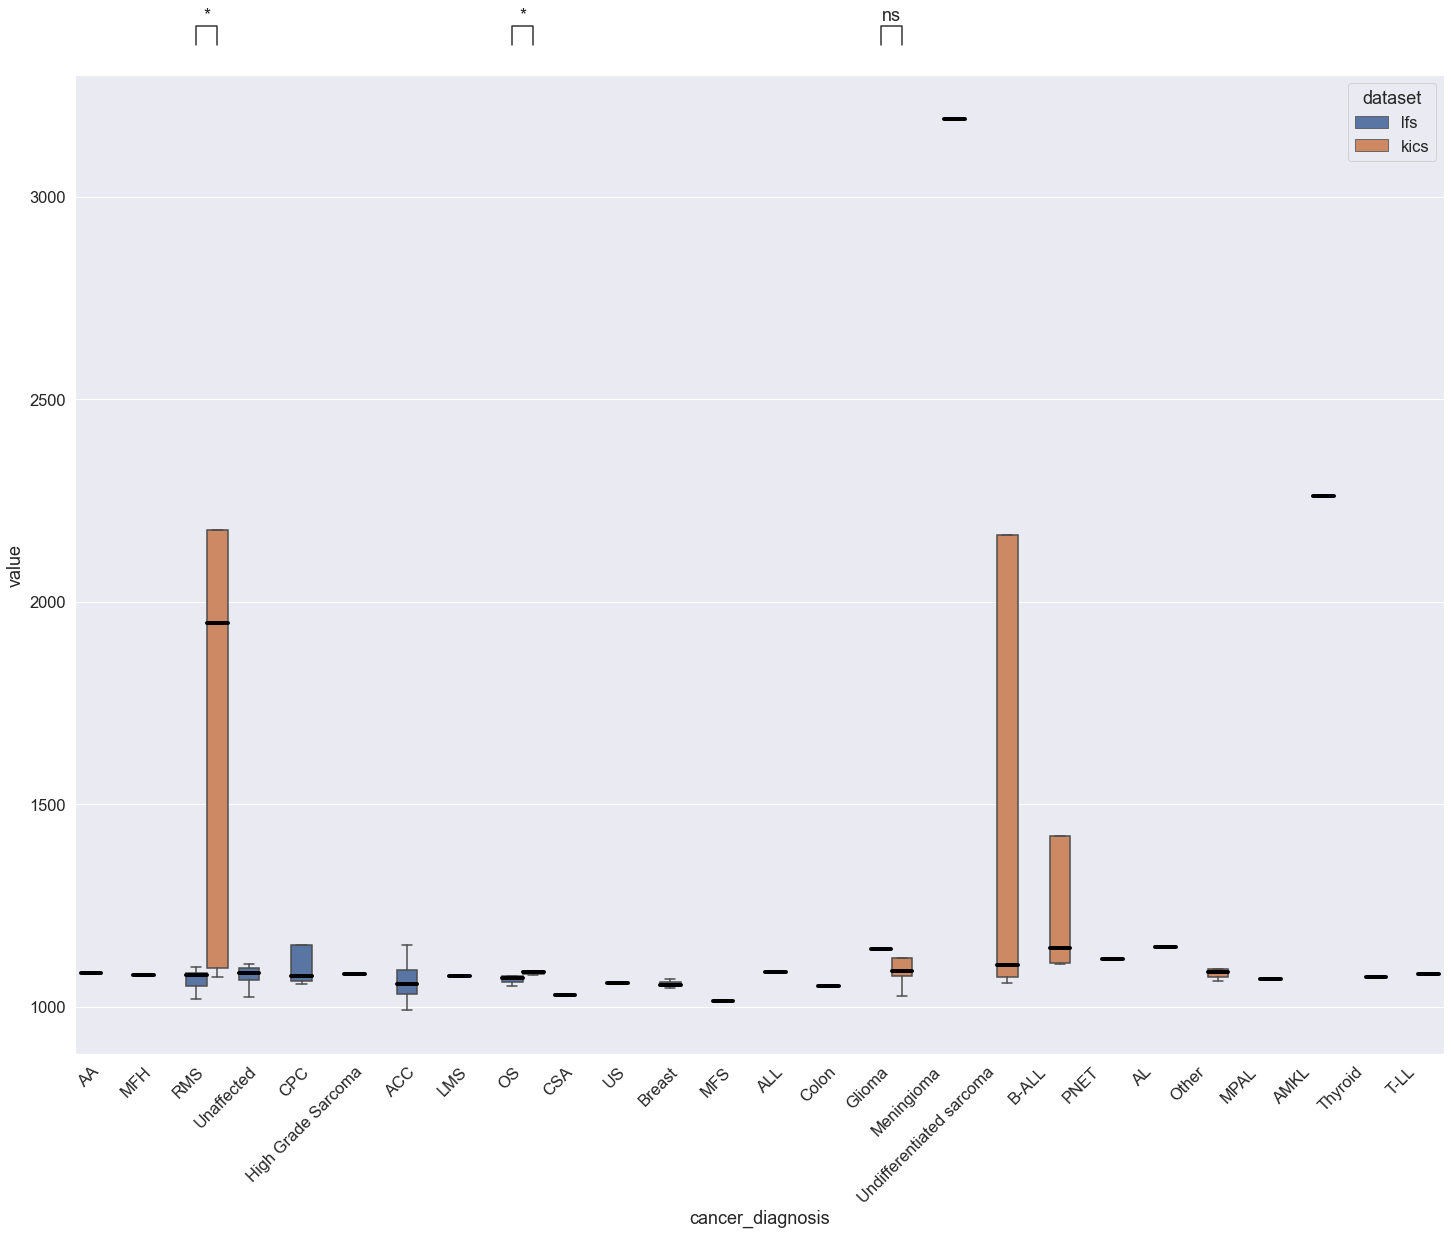

In [46]:
kicsTissue = bigKdf.drop(['SV_type','abbv_id','sample', 'tumour_class', 'cancer_diagnosis','ageofonset'], axis=1)
kicsDiag = bigKdf.drop(['SV_type','abbv_id','sample', 'tumour_class','ageofonset', 'tissue_type'], axis=1)

lfsTissue = bigLdf.drop(['cancer_diagnosis', 'sample','SV_type','ageofonset'],axis=1)
lfsDiag = bigLdf.drop(['tissue_type', 'sample','SV_type','ageofonset'],axis=1)

graphSVTissue(kicsDiag, lfsDiag, uniqueDiag, False)

  Samples_ID  tissue_type  freq
6     284386  Soft Tissue  4516
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.003e-02 U_stat=1.000e+01
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=2.000e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.613e-01 U_stat=3.500e+01
Bone_lfs vs. Bone_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.577e-02 U_stat=0.000e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.729e-01 U_stat=5.000e-01


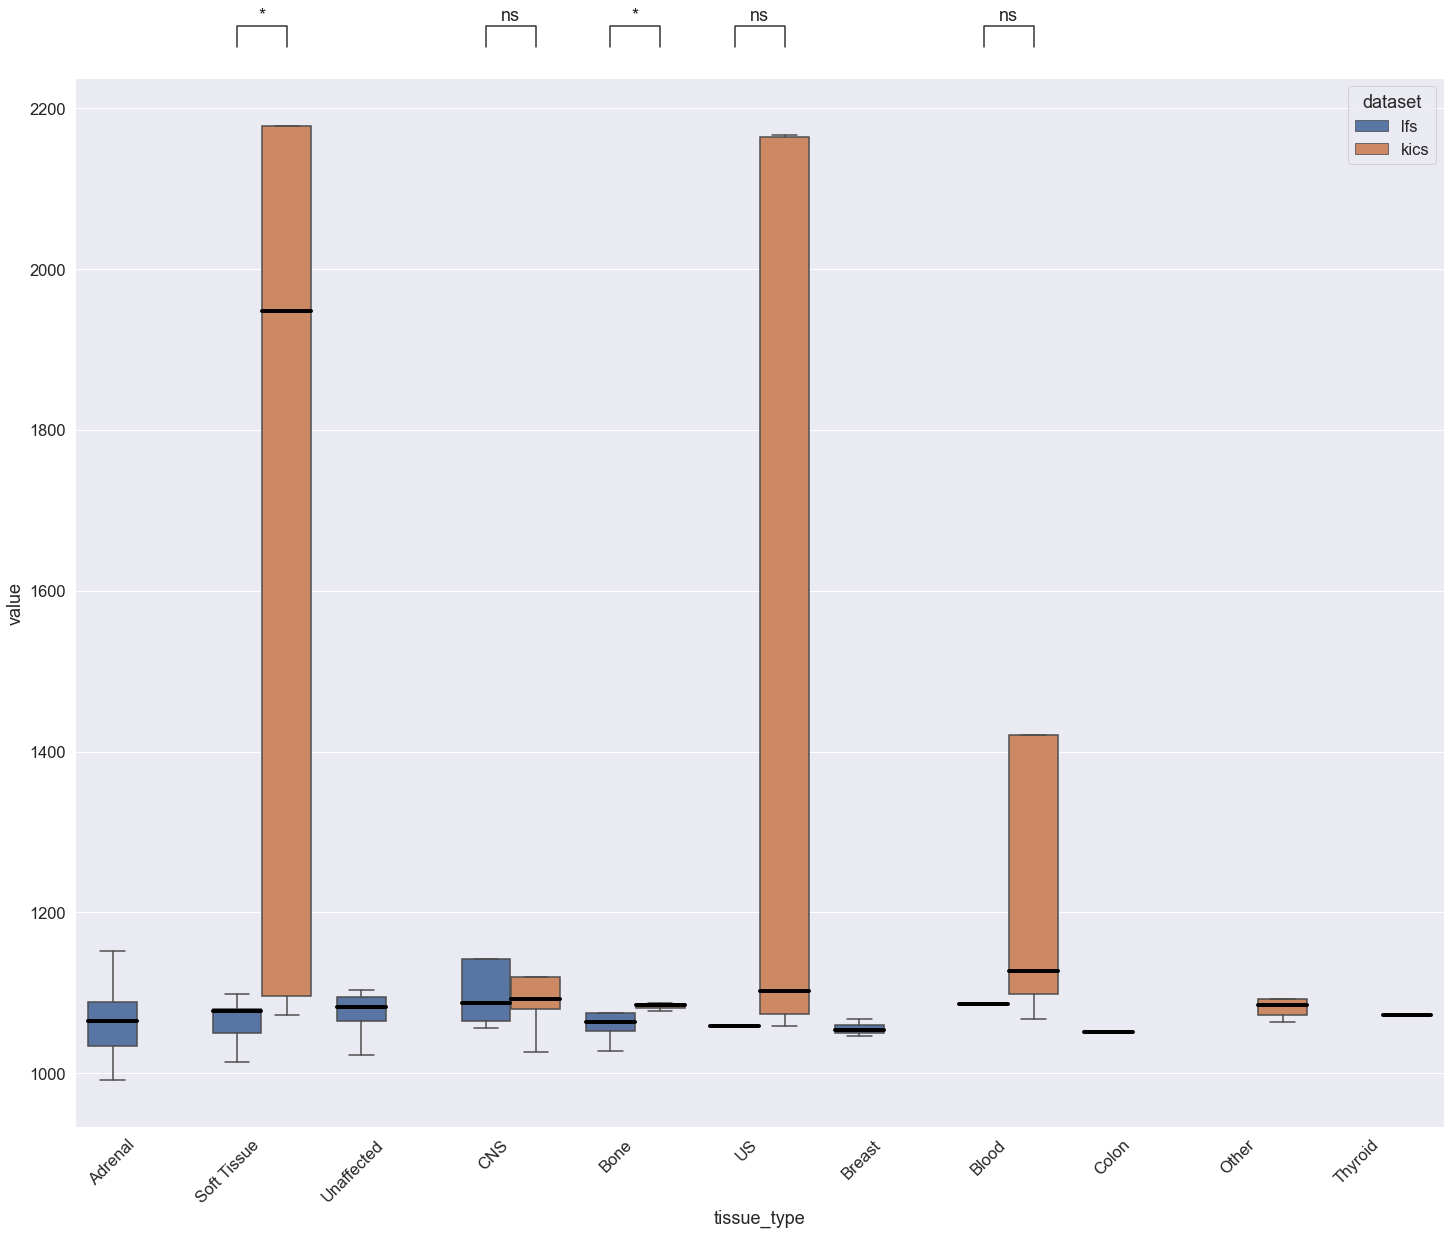

In [47]:
graphSVTissue(kicsTissue, lfsTissue, uniqueTissue, True)

In [48]:
print(bigLdf.columns)

Index(['Samples_ID', 'SV_type', 'ALT', 'sample', 'tissue_type',
       'cancer_diagnosis', 'ageofonset'],
      dtype='object')


In [49]:
"""
Creating DFs needed for lfs vs kics tissue and diag
"""
kDF = bigKdf.drop(['SV_type', 'abbv_id', 'sample', 'tumour_class','ageofonset'],axis=1)
lDF = bigLdf.drop(['SV_type','sample','ageofonset'],axis=1)

kAlu = kDF.loc[kDF['ALT'] == 'ALU']
kLine = kDF.loc[kDF['ALT'] == 'LINE1']
kSva = kDF.loc[kDF['ALT'] == 'SVA']

lAlu = lDF.loc[lDF['ALT'] == 'ALU']
lLine = lDF.loc[lDF['ALT'] == 'LINE1']
lSva = lDF.loc[lDF['ALT'] == 'SVA']

  Samples_ID  tissue_type  freq
6     284386  Soft Tissue  4184
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.994e-02 U_stat=1.000e+01
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.367e-01 U_stat=1.500e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.001e-01 U_stat=3.400e+01
Bone_lfs vs. Bone_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.429e-01 U_stat=2.000e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=1.000e+00


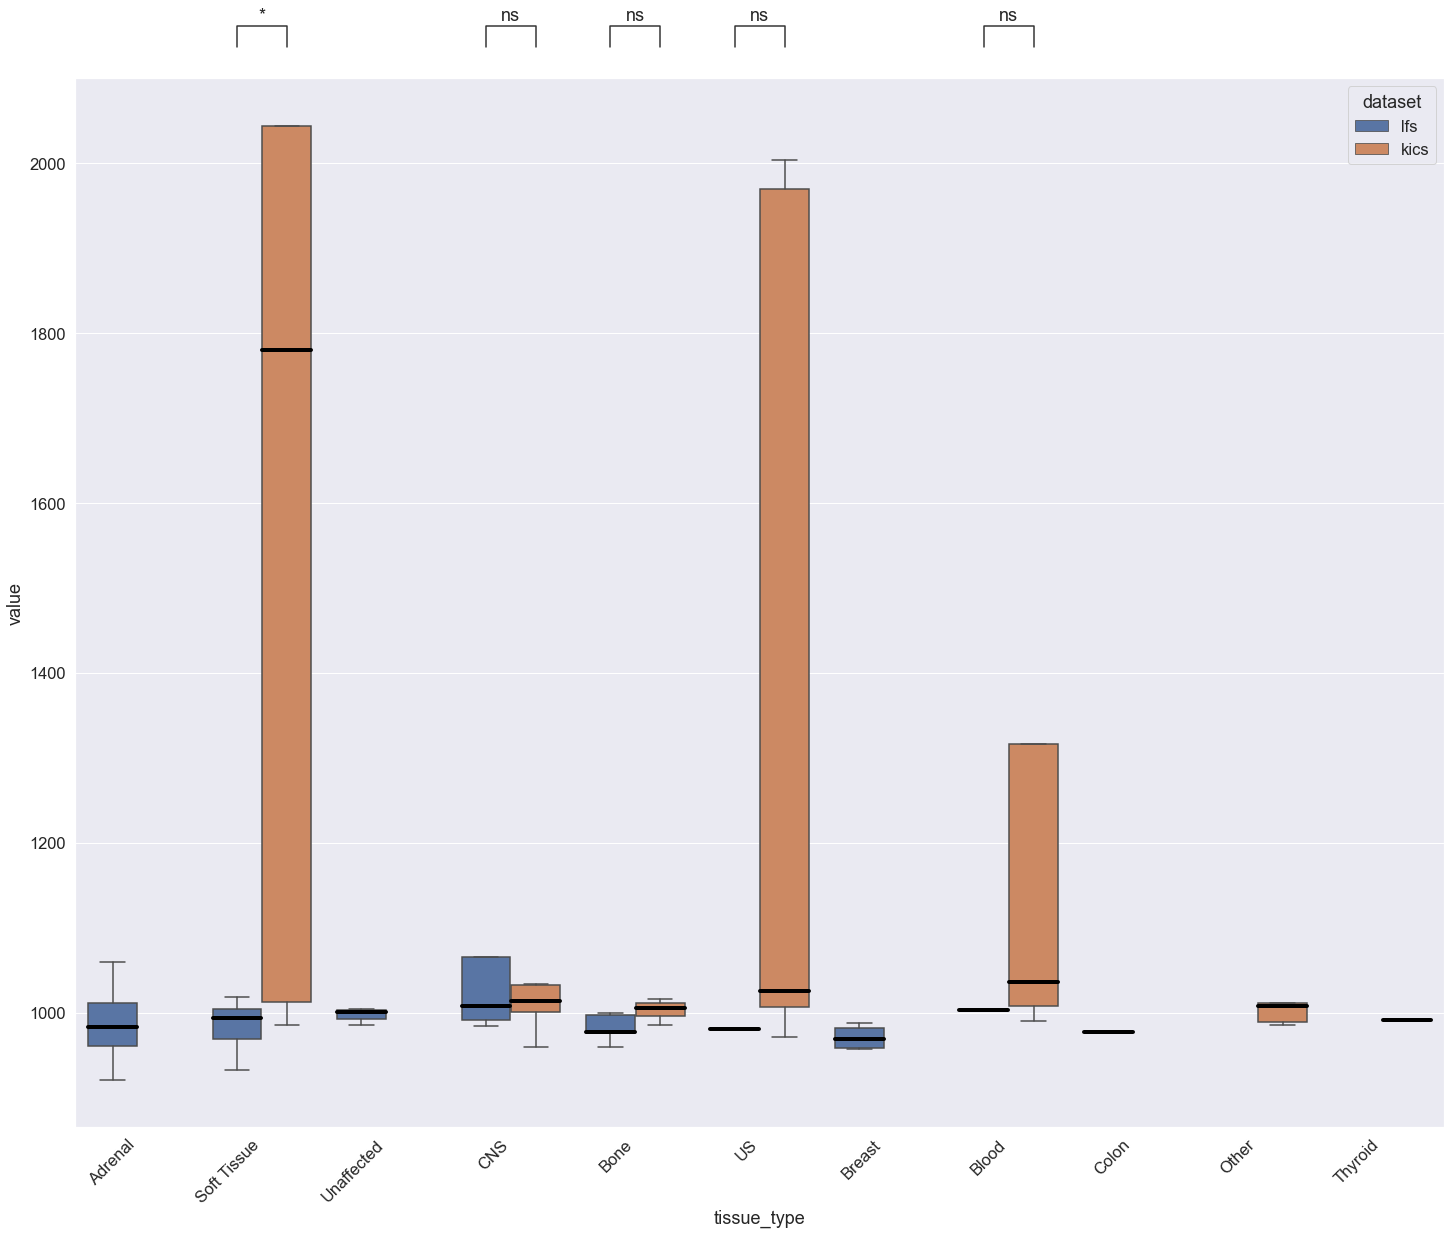

In [50]:
graphSVTissue(kAlu.drop(['cancer_diagnosis'],axis=1), lAlu.drop(['cancer_diagnosis'],axis=1), uniqueTissue, True)


Empty DataFrame
Columns: [Samples_ID, tissue_type, freq]
Index: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.344e-02 U_stat=7.000e+00
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.889e-01 U_stat=3.000e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.117e-01 U_stat=2.950e+01
Bone_lfs vs. Bone_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.462e-01 U_stat=5.000e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.333e-01 U_stat=0.000e+00


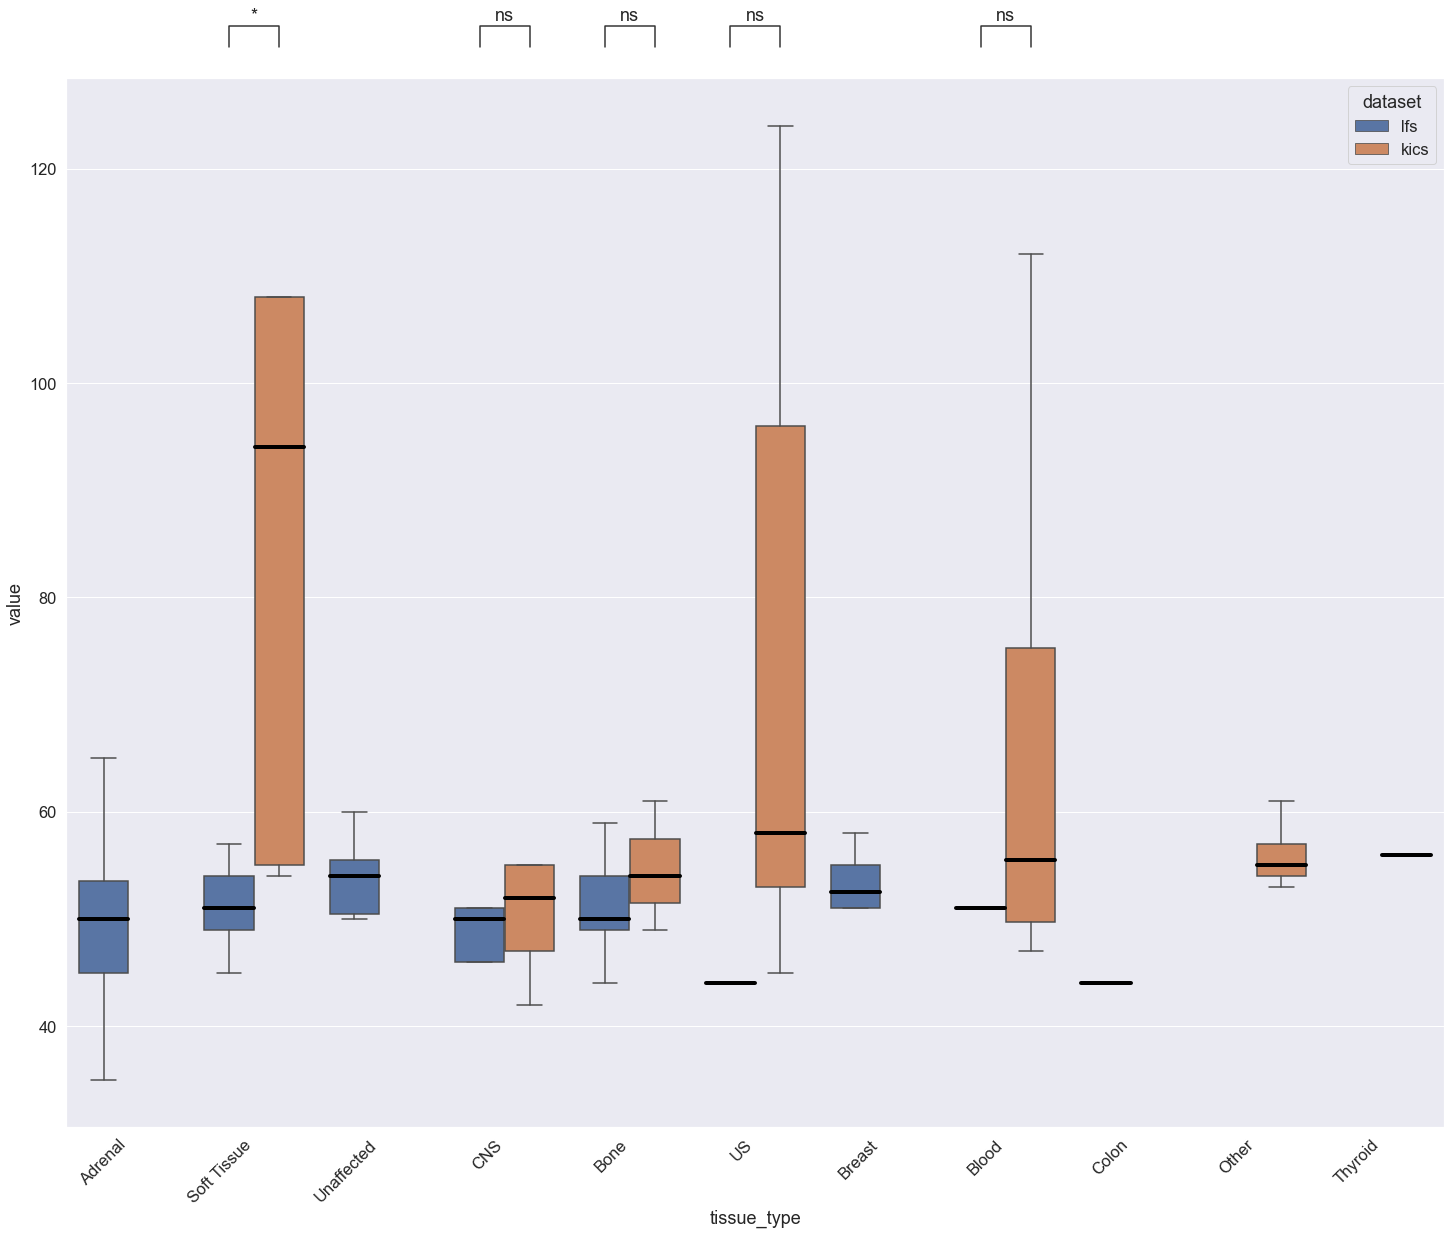

In [51]:
graphSVTissue(kLine.drop(['cancer_diagnosis'],axis=1), lLine.drop(['cancer_diagnosis'],axis=1), uniqueTissue, True)

Empty DataFrame
Columns: [Samples_ID, tissue_type, freq]
Index: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.000e-02 U_stat=1.250e+01
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.596e-01 U_stat=2.000e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.059e-01 U_stat=2.750e+01
Bone_lfs vs. Bone_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.857e-01 U_stat=9.000e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.000e+00


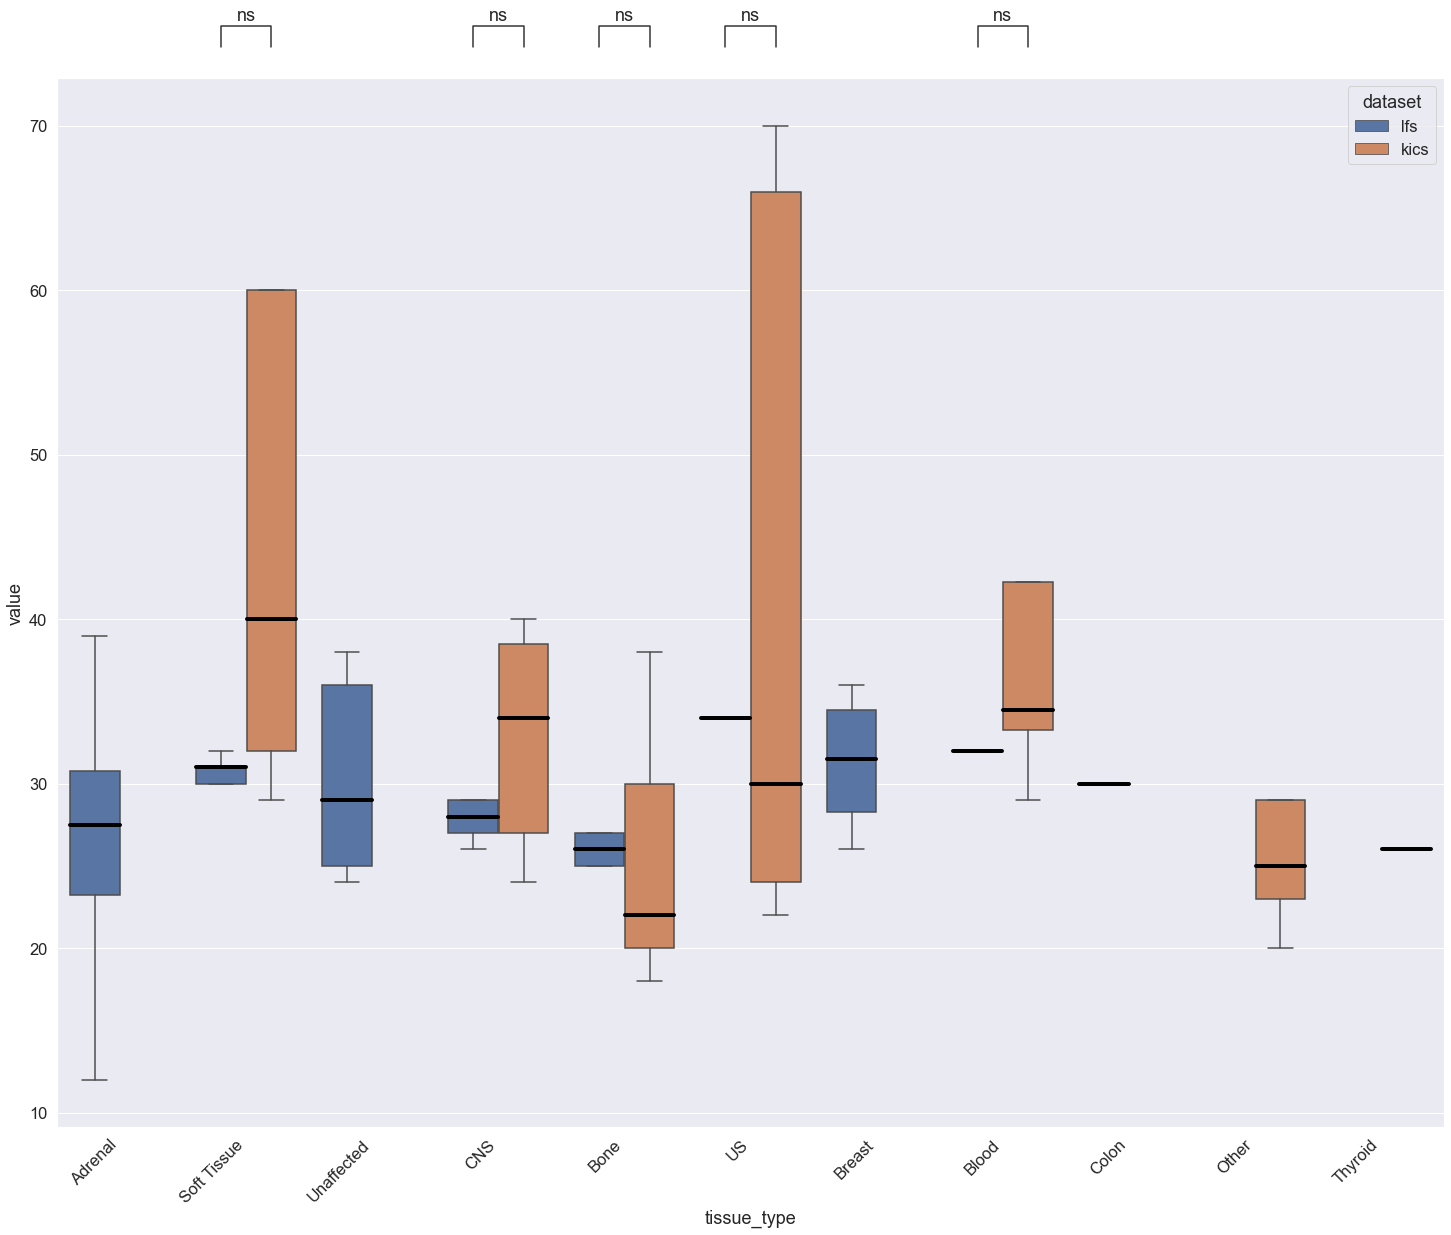

In [52]:
graphSVTissue(kSva.drop(['cancer_diagnosis'],axis=1), lSva.drop(['cancer_diagnosis'],axis=1), uniqueTissue, True)

  Samples_ID cancer_diagnosis  freq
6     284386              RMS  4184
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.286e-01 U_stat=1.100e+01
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.286e-01 U_stat=2.000e+00
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.503e-02 U_stat=7.000e+00


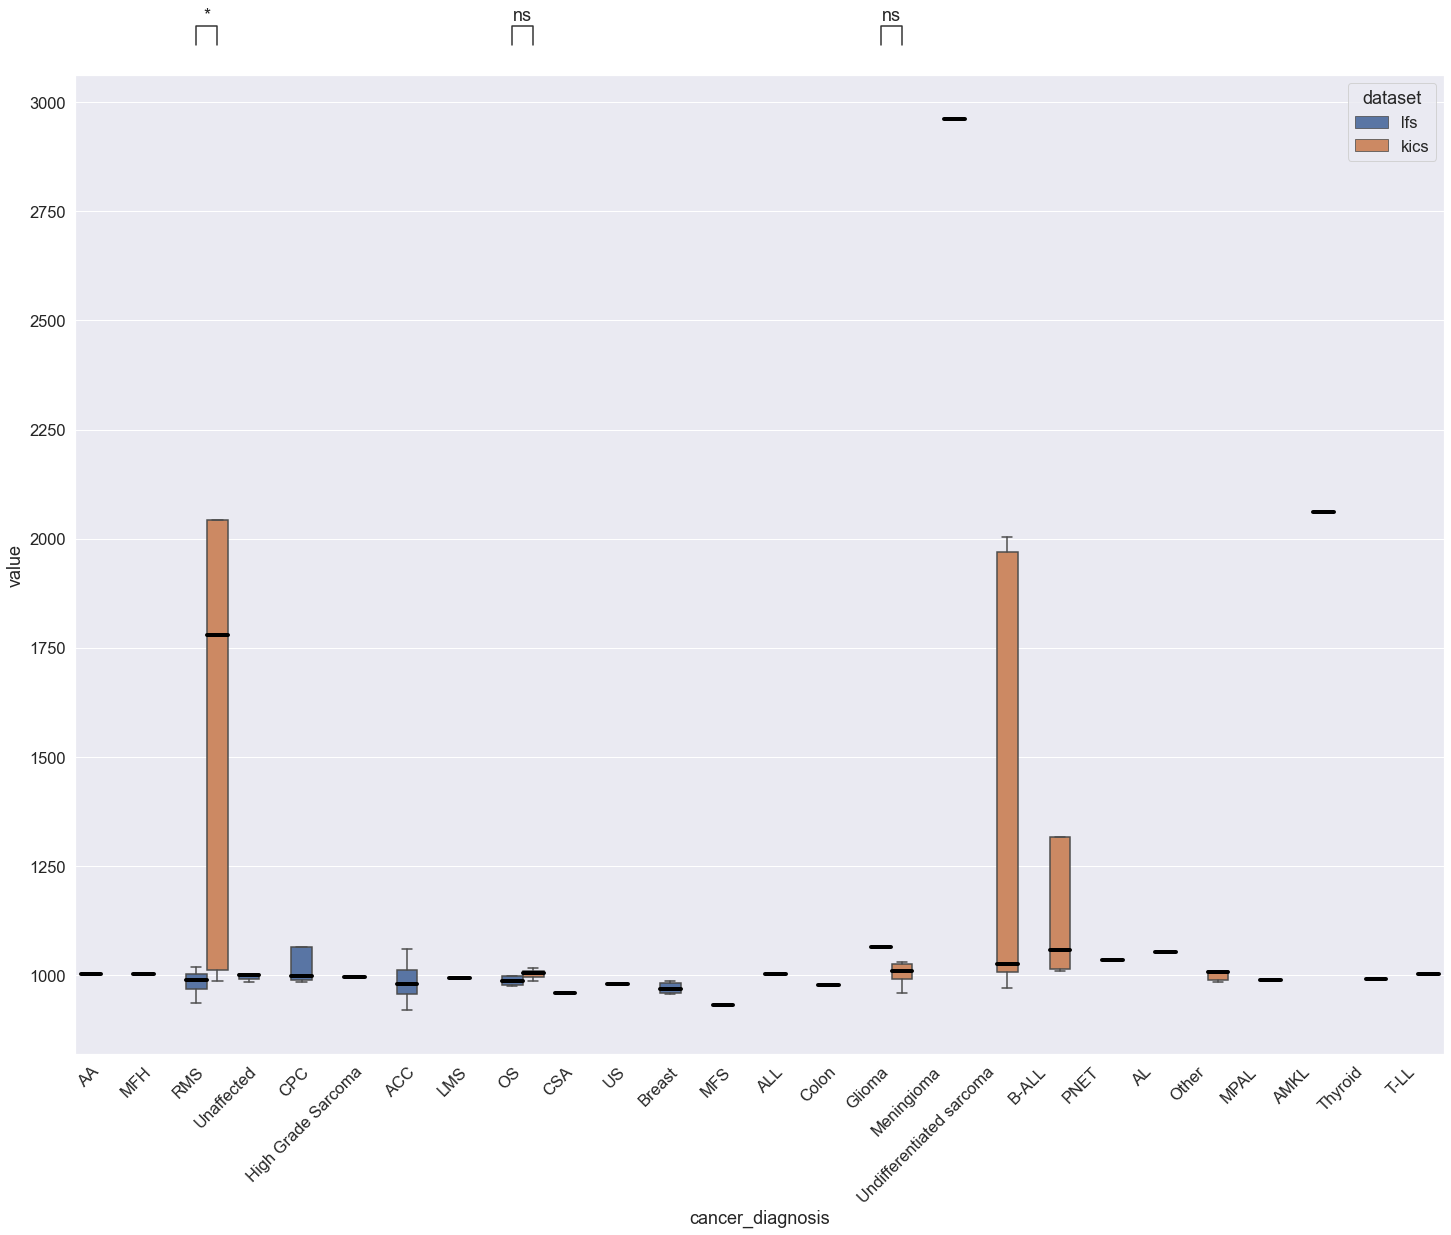

In [53]:
#diagnosis
graphSVTissue(kAlu.drop(['tissue_type'],axis=1), lAlu.drop(['tissue_type'],axis=1), uniqueDiag, False)

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, freq]
Index: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.086e-01 U_stat=4.500e+00
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=5.000e+00
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.280e-02 U_stat=5.000e+00


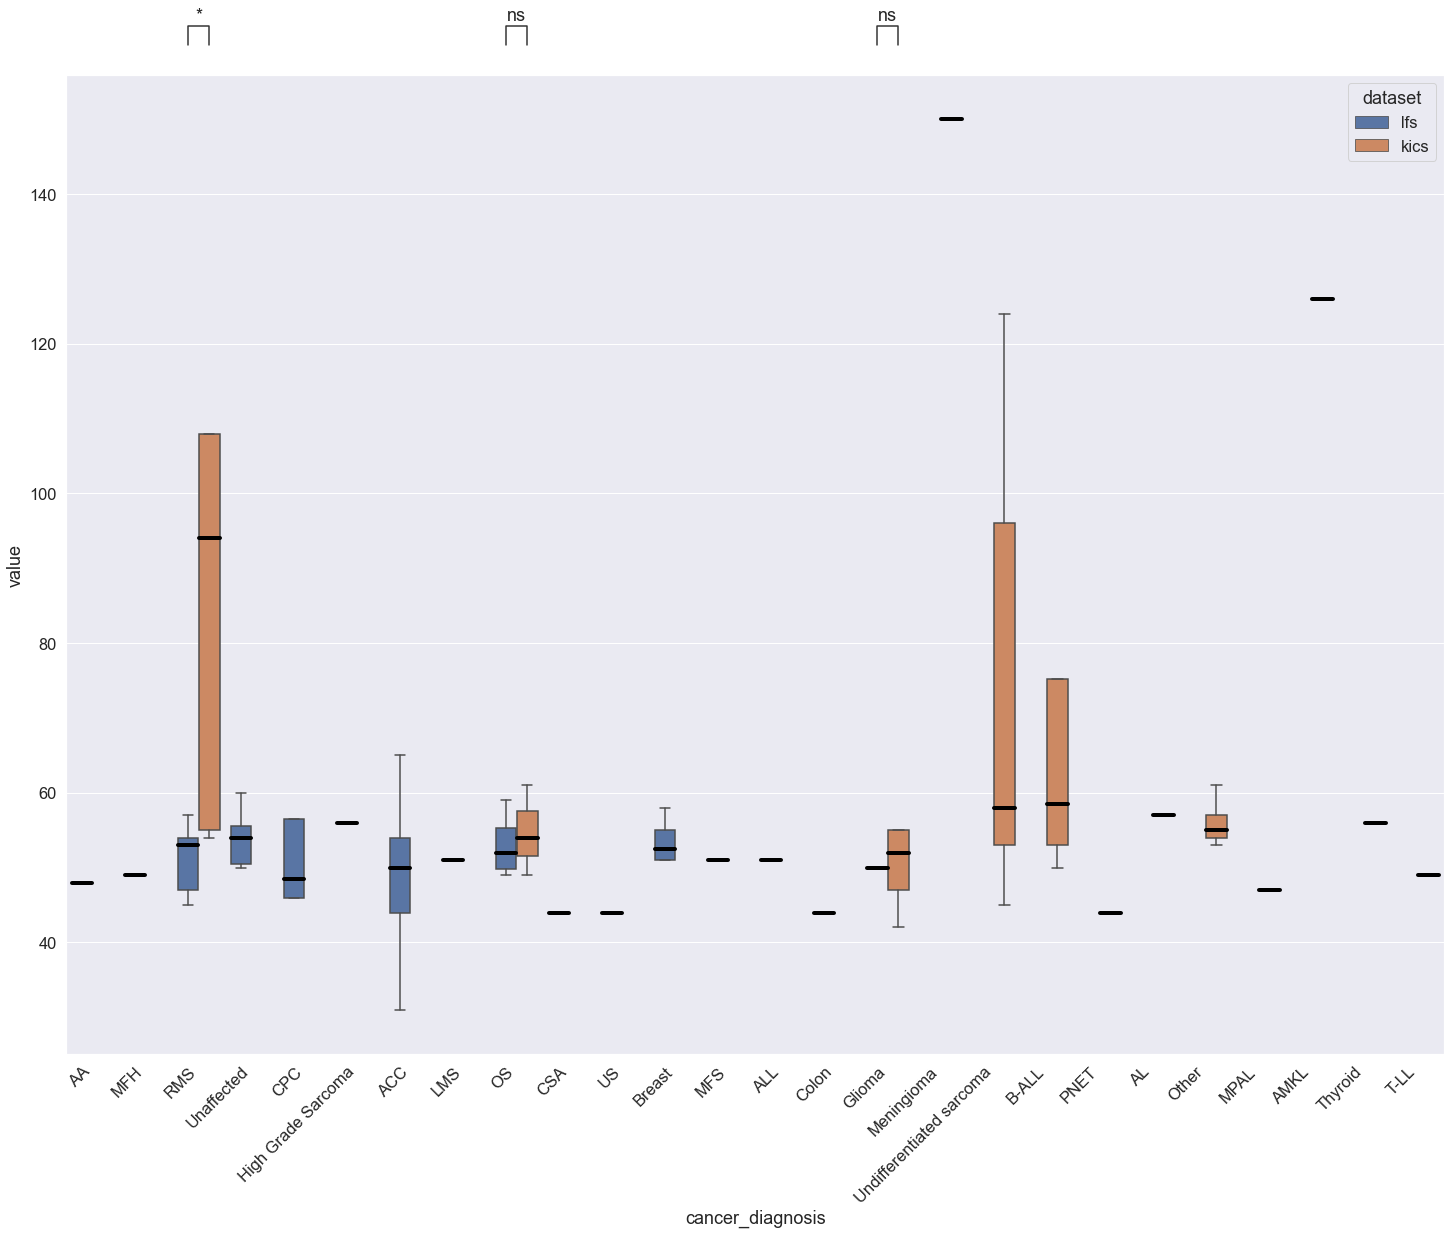

In [54]:
graphSVTissue(kLine.drop(['tissue_type'],axis=1), lLine.drop(['tissue_type'],axis=1), uniqueDiag, False)

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, freq]
Index: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.190e-01 U_stat=4.000e+00
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=7.000e+00
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.206e-01 U_stat=1.050e+01


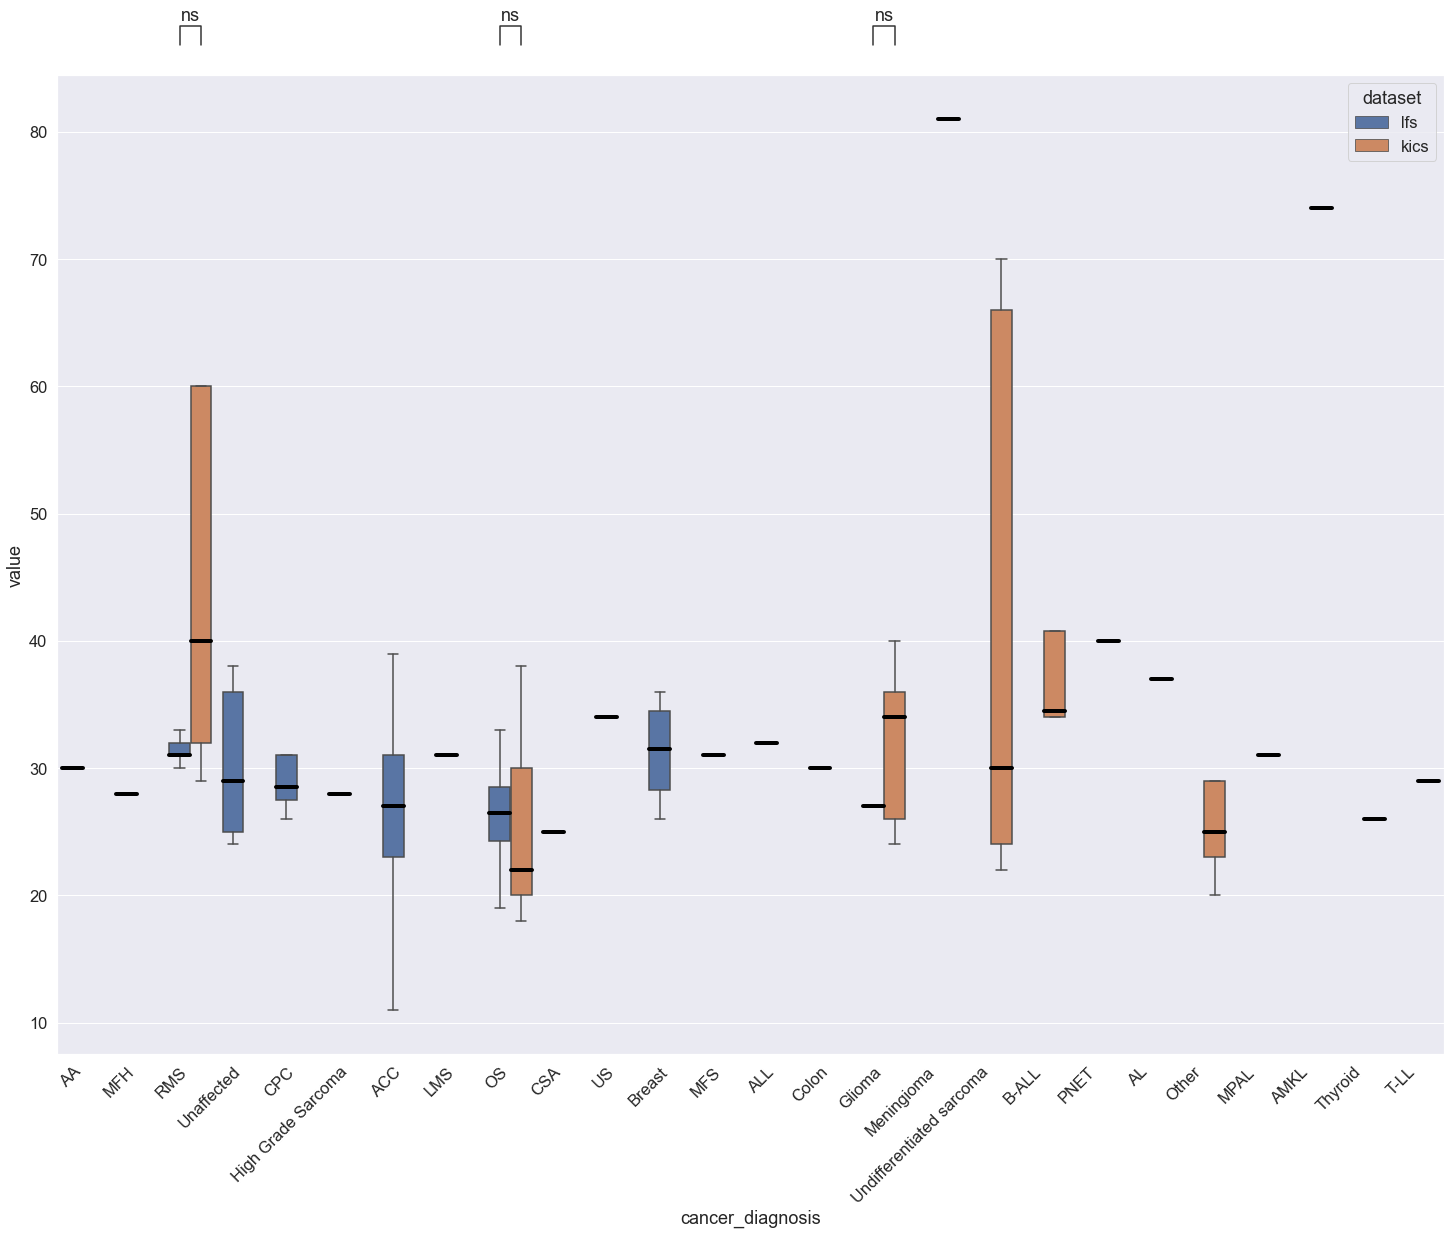

In [55]:
graphSVTissue(kSva.drop(['tissue_type'],axis=1), lSva.drop(['tissue_type'],axis=1), uniqueDiag, False)

In [56]:
print(kSva[''])
kLine
kAlu

KeyError: ''